# $Question 2$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import KDTree
import tracemalloc
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
def generate_random_dataset(N, D):
    return np.random.randn(N, D)

In [6]:
# Naive KNN implementation
class NaiveKNN:
    def __init__(self, train_data):
        self.train_data = train_data

    def query(self, test_point, K):
        distances = np.sqrt(np.sum((self.train_data - test_point)**2, axis=1))
        nearest_indices = np.argsort(distances)[:K]
        return nearest_indices
    
def naive_KNN(k, dataset, test_point):
  distances = []

  for i in range(len(dataset)):
    distance = np.sqrt(np.sum((dataset[i] - test_point)**2))
    distances.append((i, distance))
  sorted_distances = sorted(distances, key=lambda x: x[1])
  neighbors = [dataset[index] for (index, dist) in sorted_distances[:k]]

  return neighbors
def creating_bins(p, dataset):
    n, d = dataset.shape
    ones_mat = np.ones((n, 1))

    X = np.hstack([ones_mat, dataset])
    W = np.random.randn(d+1, p)

    H = X @ W > 0

    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_indices = H.dot(powers_of_two)

    hash_dict = {}
    for i in range(2**p):
        hash_dict[i] = []
    for i in range(n):
        index = int_indices[i]
        hash_dict[index].append(i)

    return W, hash_dict


def find_LSH_neighbors(dataset, test_point, p, k, W, hash_dict):
    n, d = dataset.shape
    ones = np.ones((n,1))
    X = np.hstack([ones, dataset])

    x = np.hstack([[1], test_point])
    h = x @ W > 0

    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_index = h.dot(powers_of_two)

    bucket_i = hash_dict[int_index]
    bucket = dataset[bucket_i]

    neighbors = naive_KNN(k, bucket, test_point)
    return neighbors

In [7]:
# KD-tree KNN implementation
class KDTreeKNN:
    def __init__(self, train_data):
        self.tree = KDTree(train_data)

    def query(self, test_point, K):
        distances, indices = self.tree.query(test_point, k=K)
        return indices

In [8]:
def measure_time1(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()

      neighbors = naive_KNN(K, train_data, test_point)

      end_time = time.time()

      test_time += (end_time- start_time)
    test_time /= iter
    train_time = 0

    return train_time, test_time


def measure_time2(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()

      W, hash_dict = creating_bins(3, train_data)
      ckpt_1 = time.time()

      lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)

      end_time = time.time()

      train_time += (ckpt_1- start_time)
      test_time += (end_time- ckpt_1)
    train_time/=iter
    test_time /= iter

    return train_time, test_time


def measure_time3(model, train_data, test_point, K):
    start_time = time.time()
    KDTreeKNN(train_data=train_data)
    training_time = time.time() - start_time

    start_time = time.time()
    model.query(test_point, K)
    testing_time = time.time() - start_time

    return training_time, testing_time

In [9]:
def memory_usage_knn(train_data, test_point, K):
    tracemalloc.start()
    neighbors = naive_KNN(K, train_data, test_point)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_lsh(train_data, test_point, K):
    tracemalloc.start()
    W, hash_dict = creating_bins(3, train_data)
    lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_kd(train_data, test_point, K):
    tracemalloc.start()
    model = KDTreeKNN(train_data=train_data)
    model.query(test_point, K)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

In [ ]:
def visualize_missed_neighbors(dataset, true_nearest_points, found_nearest_points, test_point, K, title):
    plt.scatter(dataset[:, 0], dataset[:, 1], color='#3776ab', label='Dataset')
    plt.scatter(test_point[0], test_point[1], color='red', marker='x', label='Test Point')
    plt.scatter(true_nearest_points[:, 0], true_nearest_points[:, 1], color='orange', label='True Nearest Neighbors')
    plt.scatter(found_nearest_points[:, 0], found_nearest_points[:, 1], color='yellow', marker = "*", label='Found Nearest Neighbors')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_knn(dataset, test_point, neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points')
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(neighbors[:, 0], neighbors[:, 1], label='k nearest neighbors', c='yellow')
  plt.legend()
  plt.show()

def plot_lsh(W, dataset, test_point, lsh_neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points')
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(lsh_neighbors[:, 0], lsh_neighbors[:, 1], label='LSH neighbors', c='yellow')

  for i in range(W.shape[1] - 1):
    plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, i][0]+W[:, i][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, i][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black')

  plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, W.shape[1]-1][0]+W[:, W.shape[1]-1][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, W.shape[1]-1][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black', label='Partitions')
  plt.ylim(top=2.5, bottom=-2.5)
  plt.title('LSH Partitions')
  plt.legend()
  plt.show()

Dataset Size: 100, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0005302820205688477
LSH KNN Training Time: 3.5036325454711915e-05
LSH KNN Testing Time: 0.00023537182807922363
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 4456) bytes
LSH KNN Memory Usage: (2280, 11120) bytes
KD-tree KNN Memory Usage: (1896, 5884) bytes


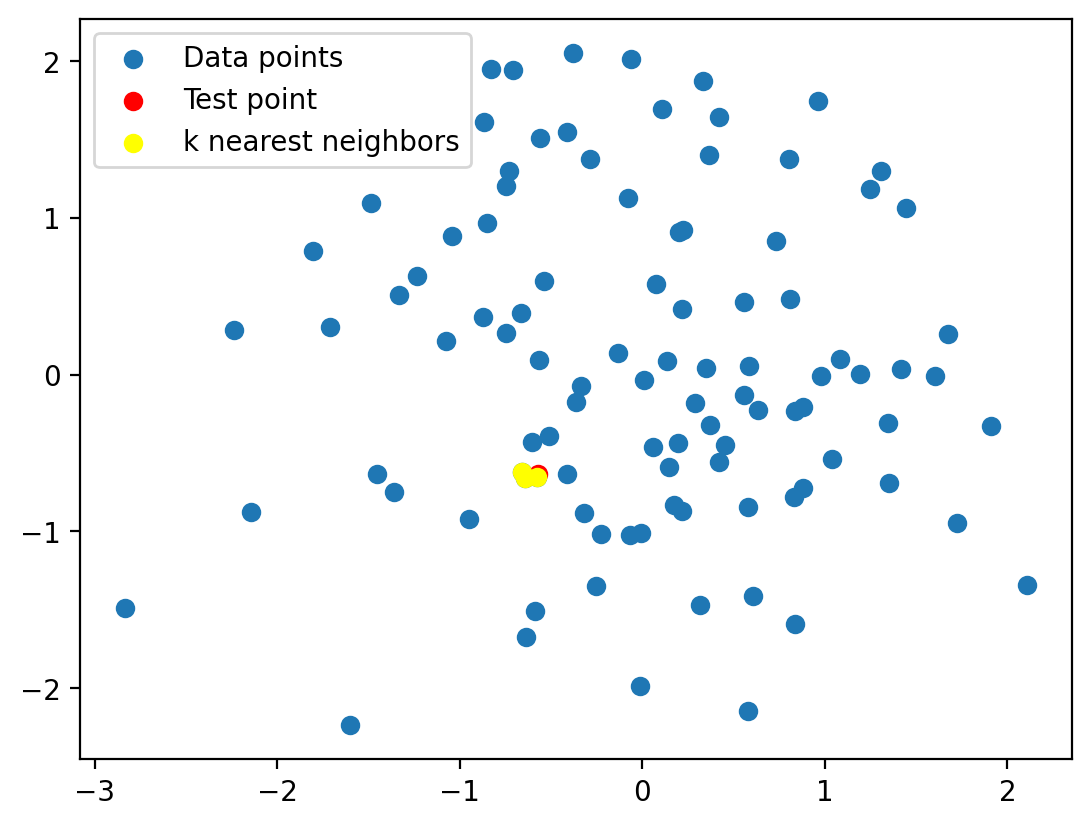

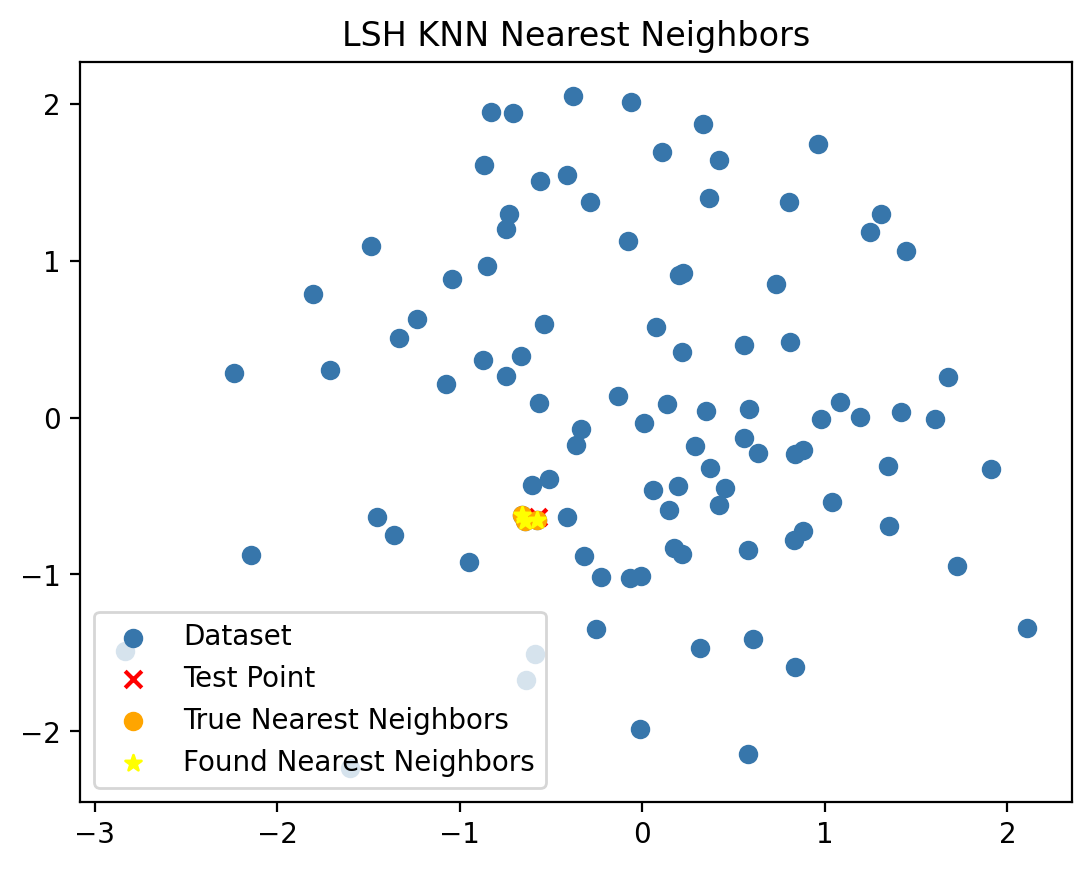

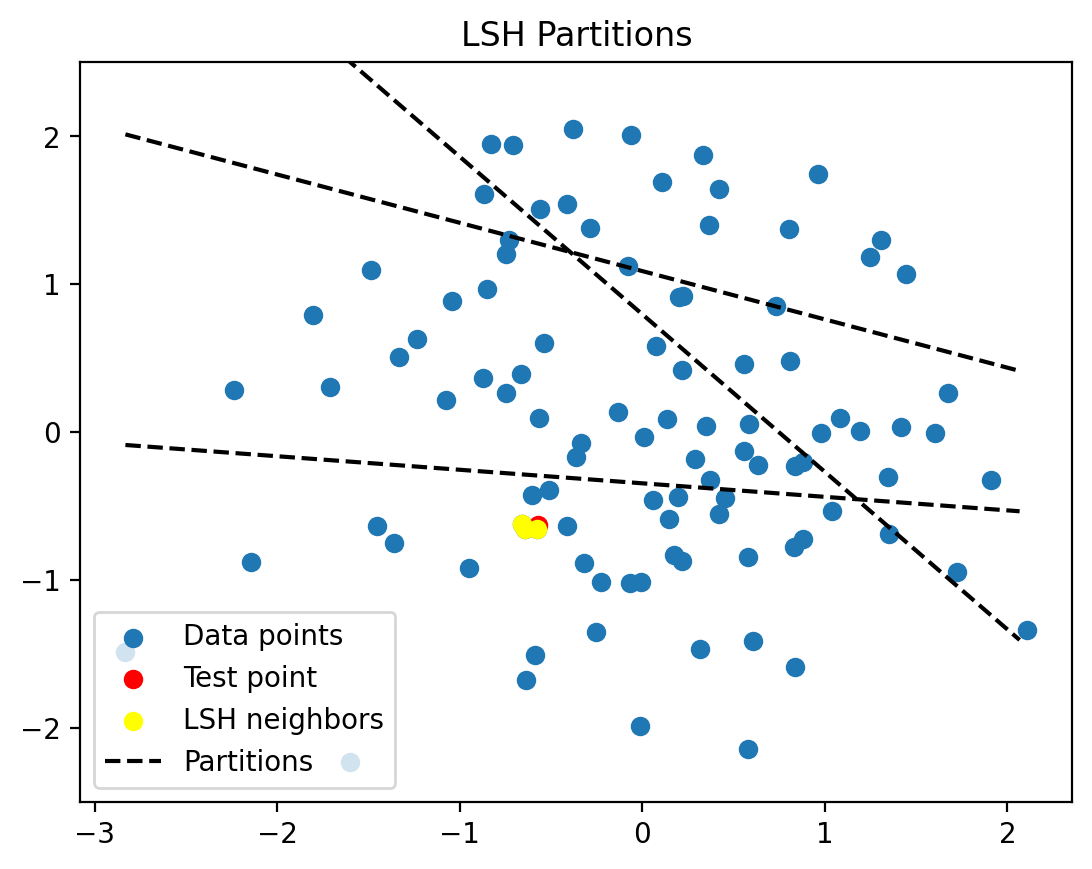

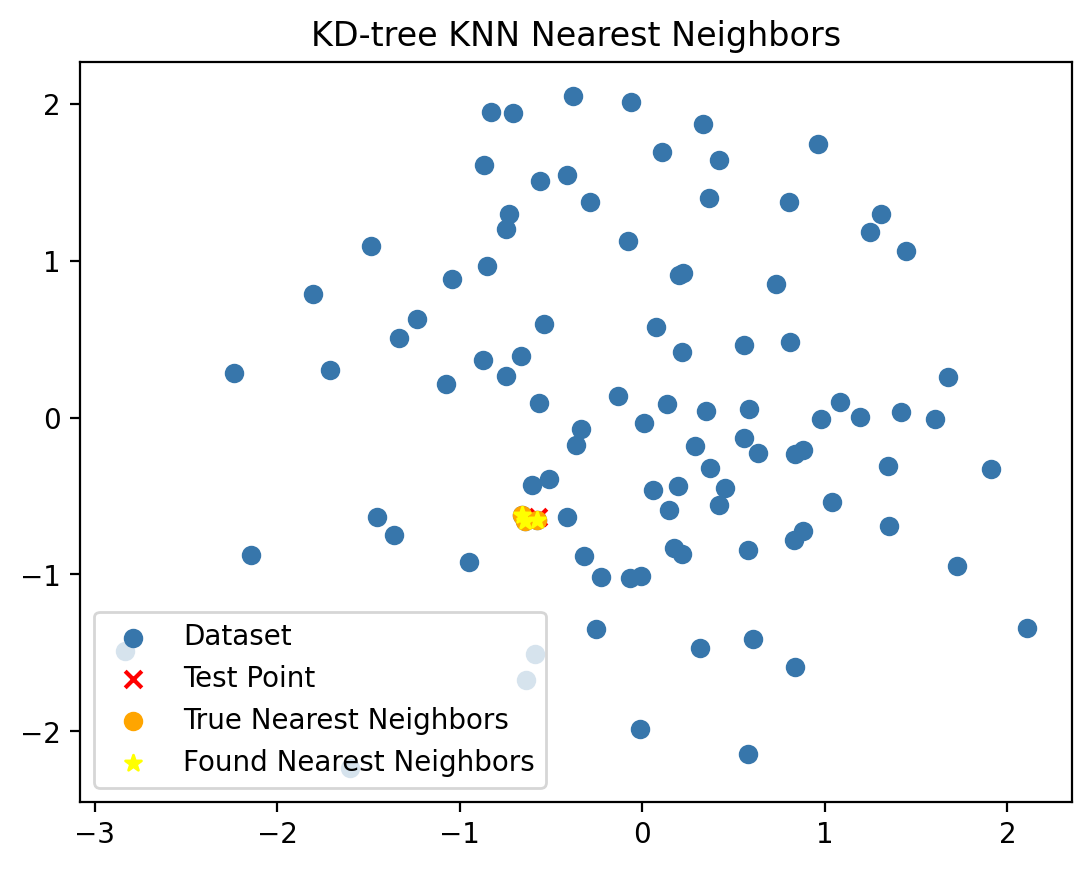

Dataset Size: 100, Dimensions: 4
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0005917758941650391
LSH KNN Training Time: 5.3023099899291995e-05
LSH KNN Testing Time: 0.00021385455131530762
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 4456) bytes
LSH KNN Memory Usage: (2910, 13512) bytes
KD-tree KNN Memory Usage: (1688, 5916) bytes


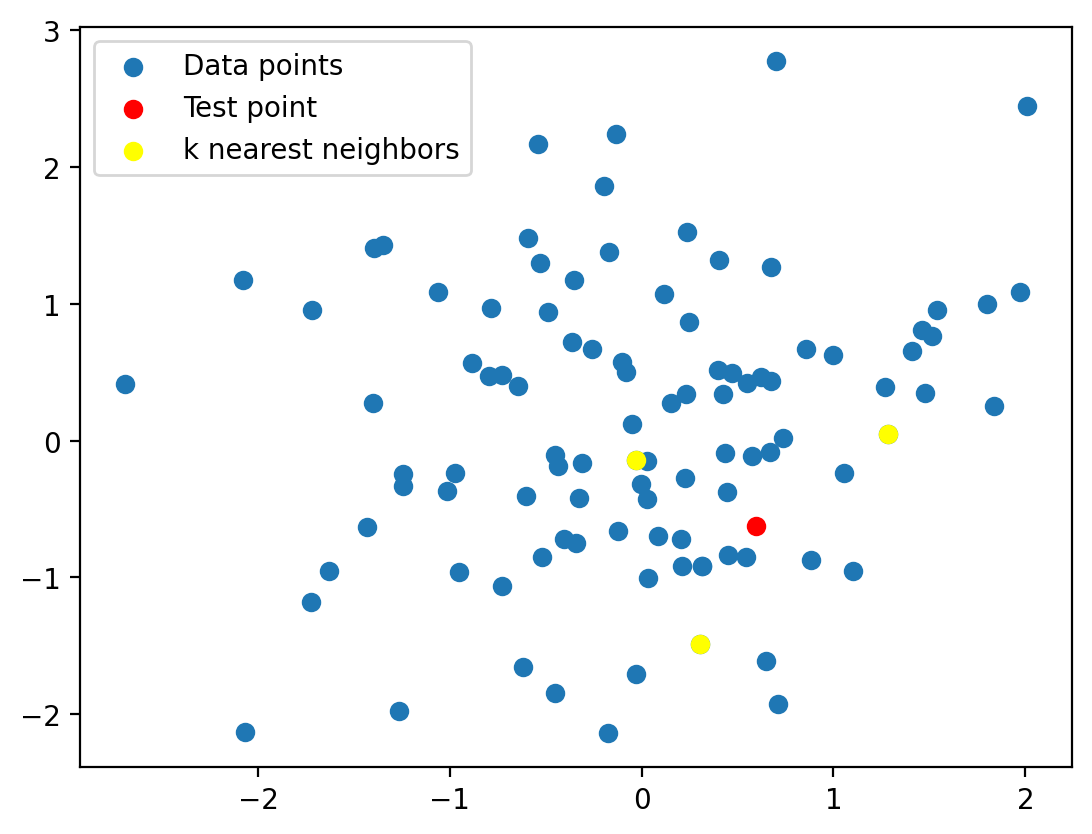

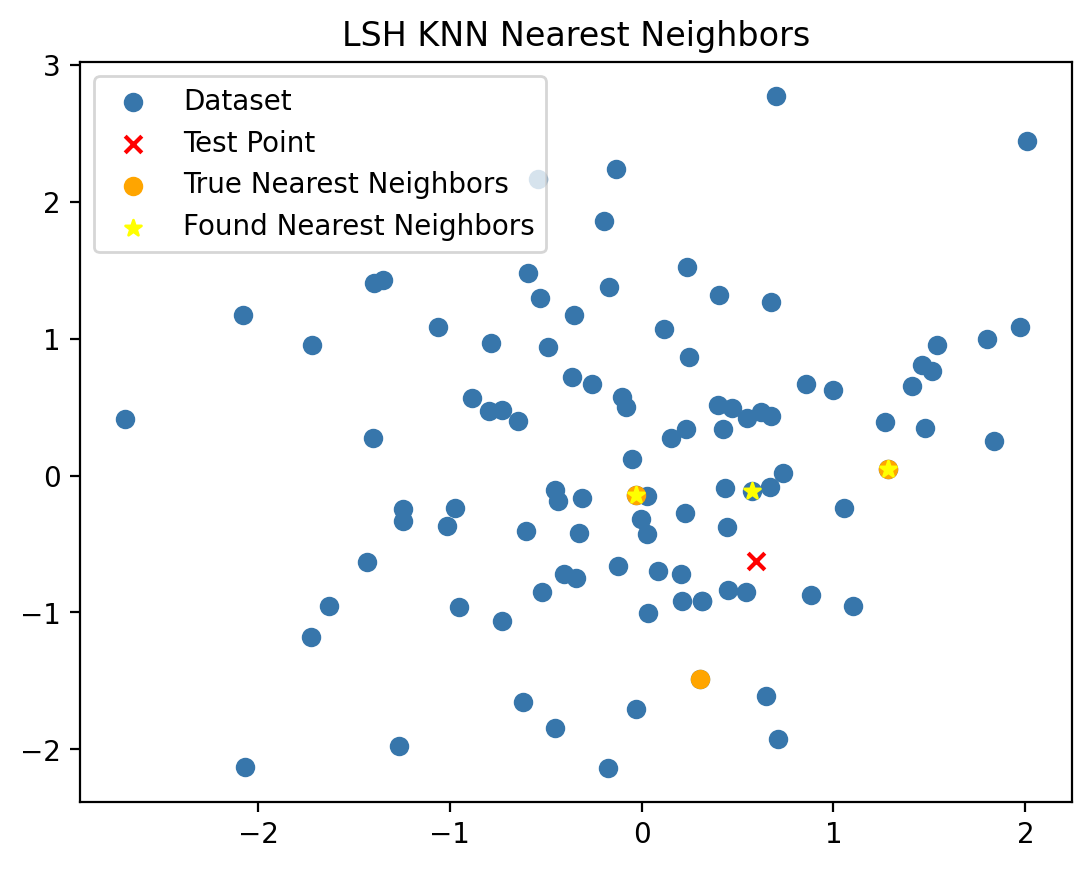

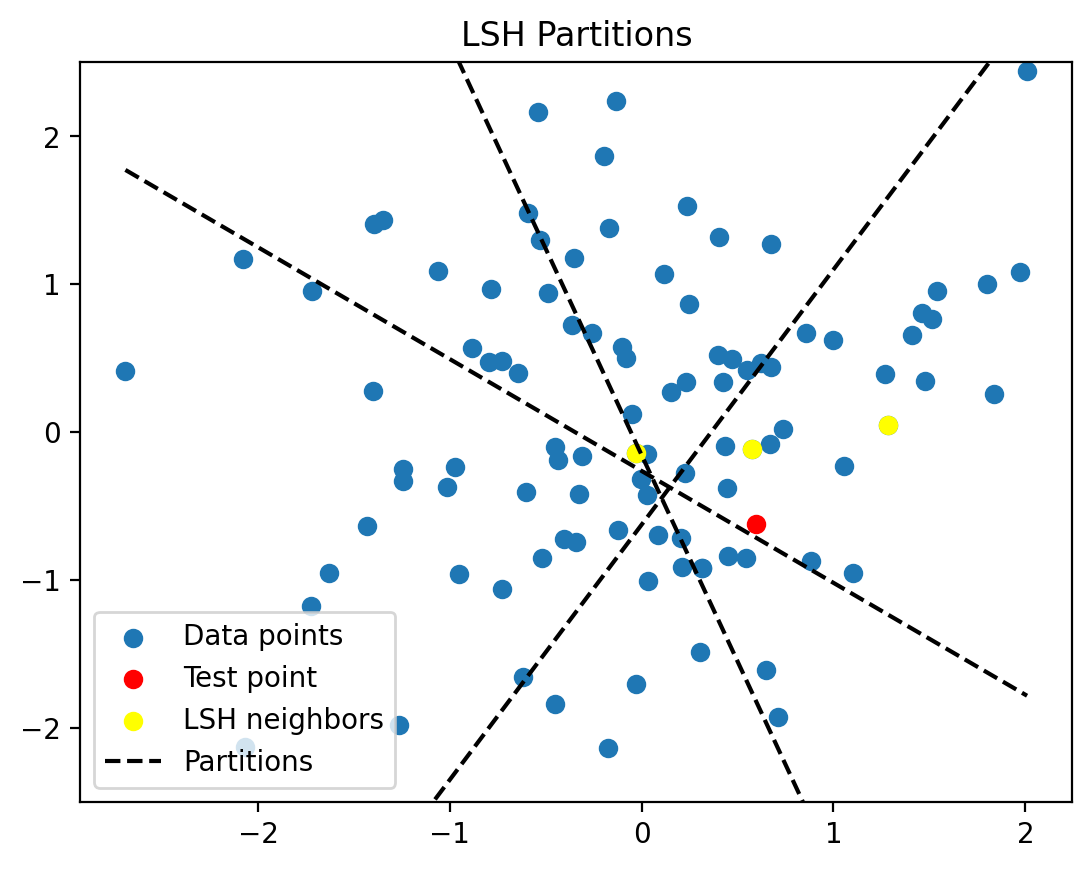

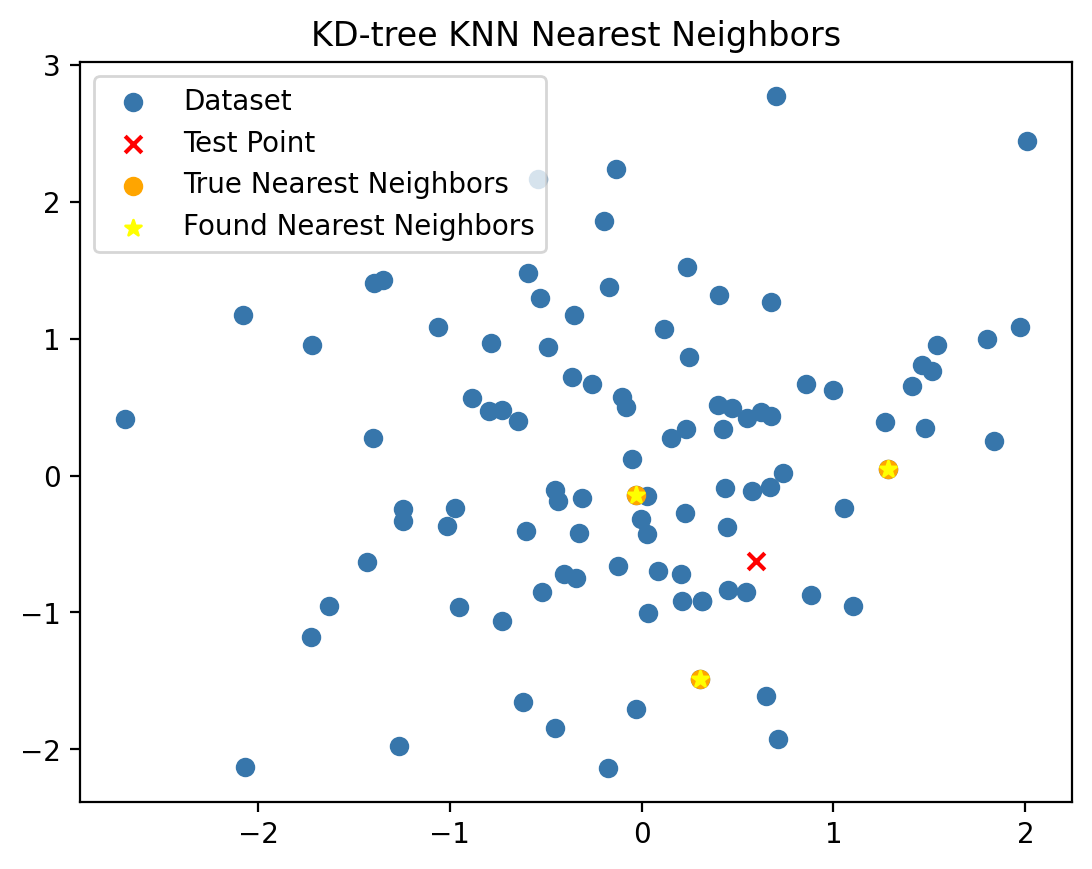

Dataset Size: 100, Dimensions: 6
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0005309116840362548
LSH KNN Training Time: 4.322195053100586e-05
LSH KNN Testing Time: 0.00014667606353759764
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 4456) bytes
LSH KNN Memory Usage: (2616, 14416) bytes
KD-tree KNN Memory Usage: (1720, 6176) bytes


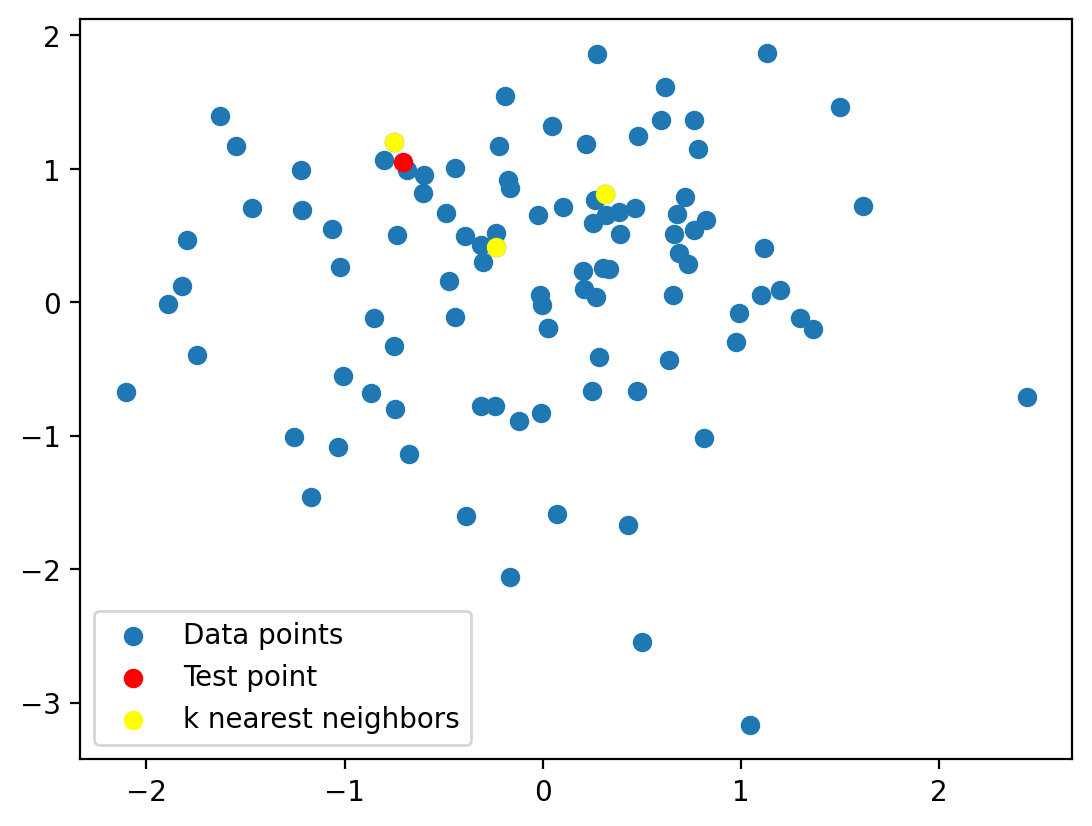

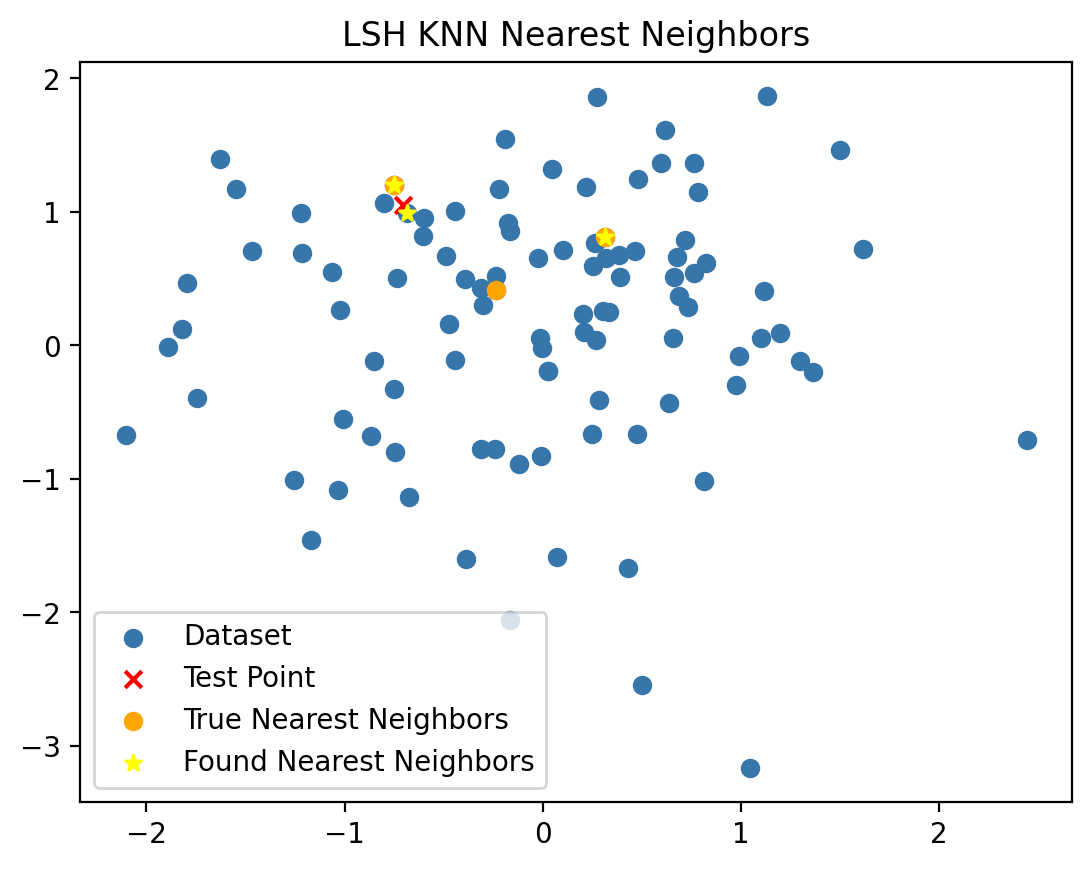

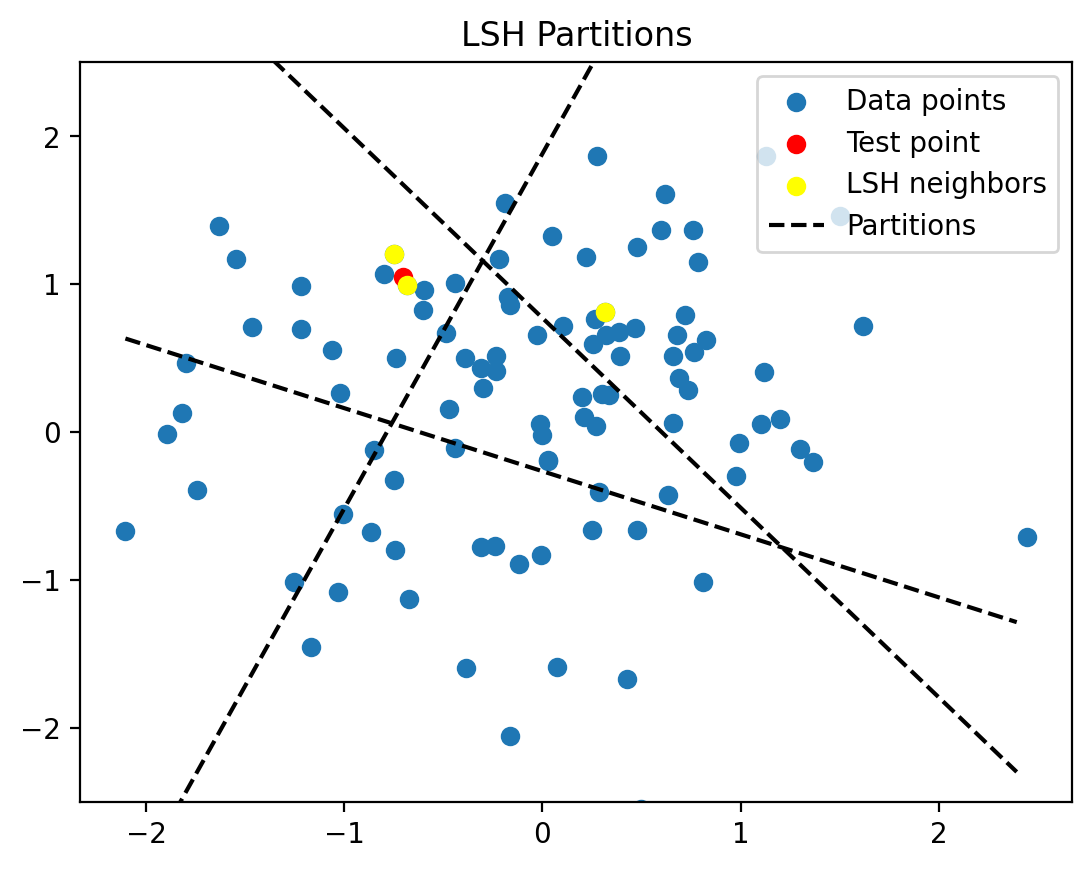

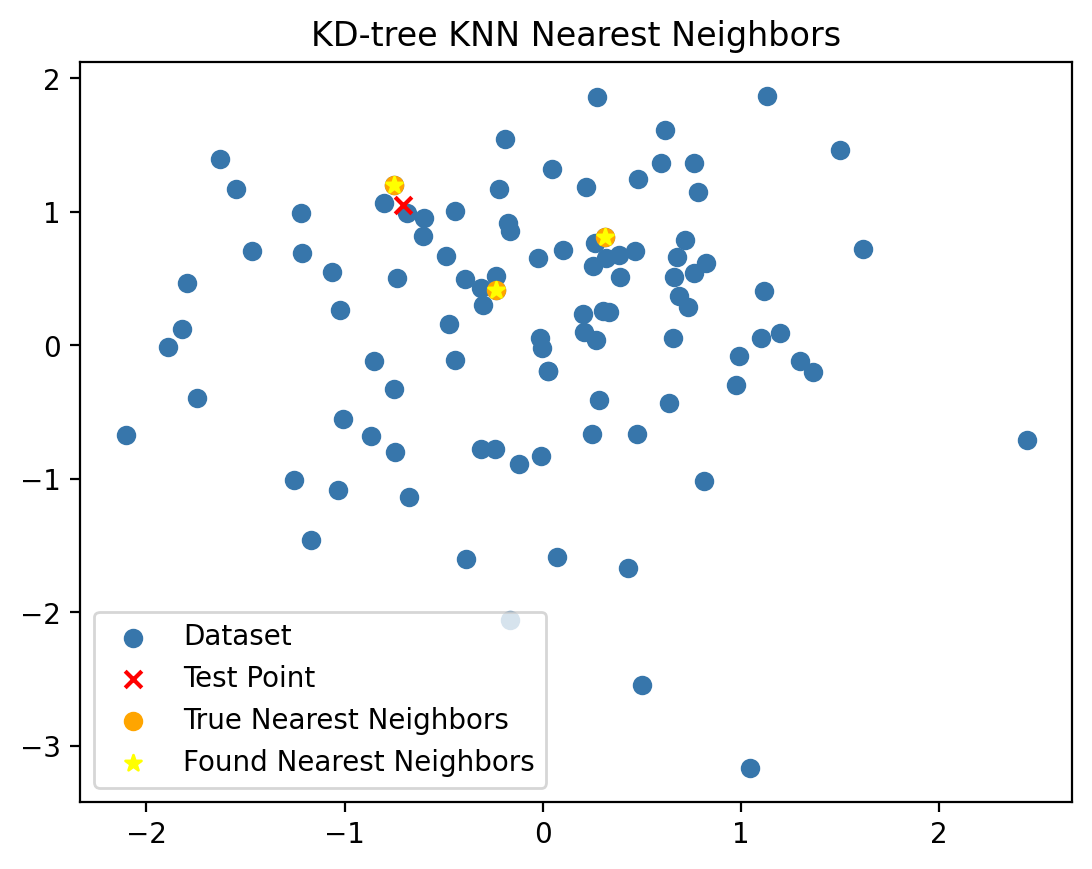

Dataset Size: 500, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.002791023015975952
LSH KNN Training Time: 0.00017644381523132323
LSH KNN Testing Time: 0.001141622543334961
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 36136) bytes
LSH KNN Memory Usage: (14888, 36207) bytes
KD-tree KNN Memory Usage: (4856, 9312) bytes


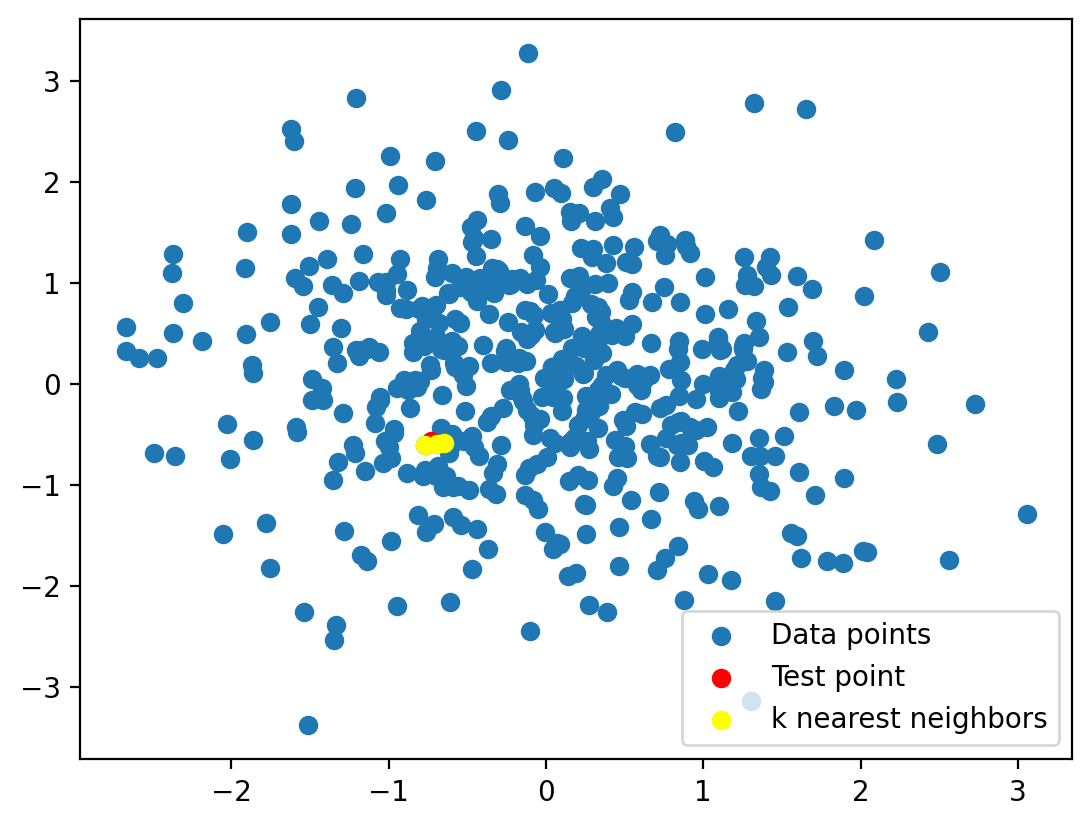

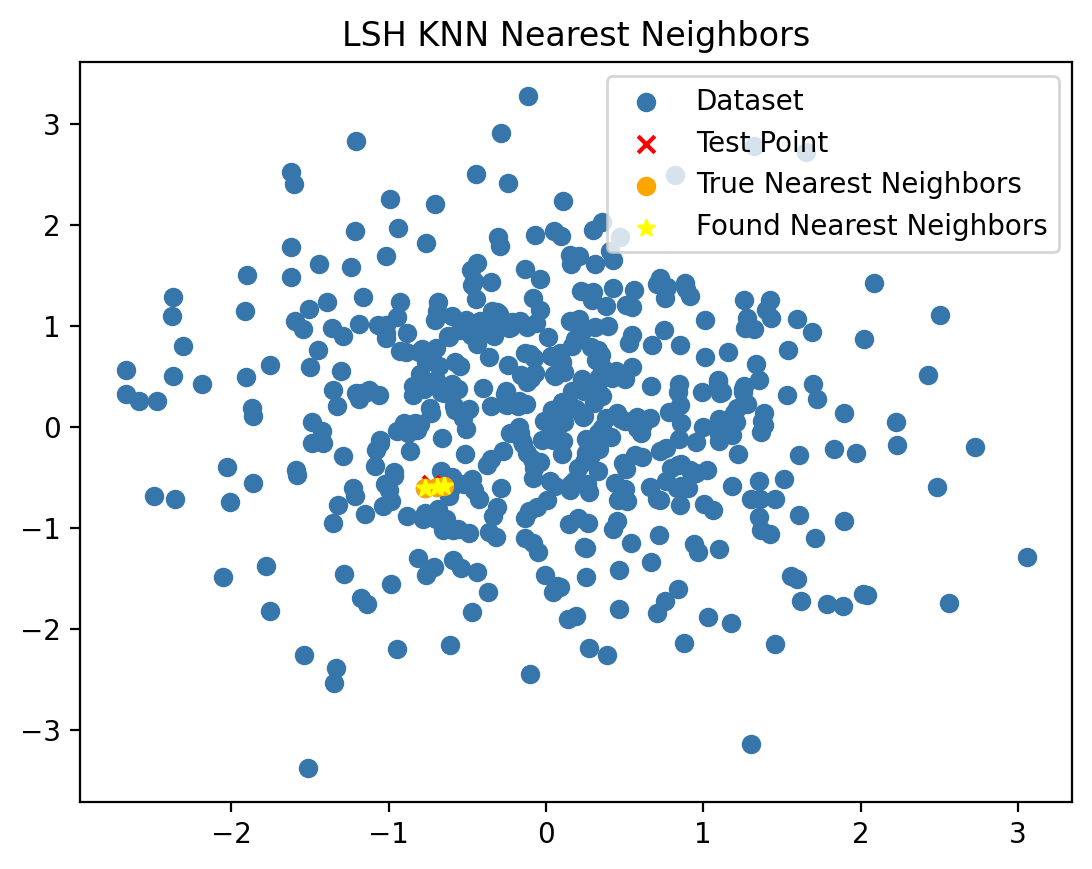

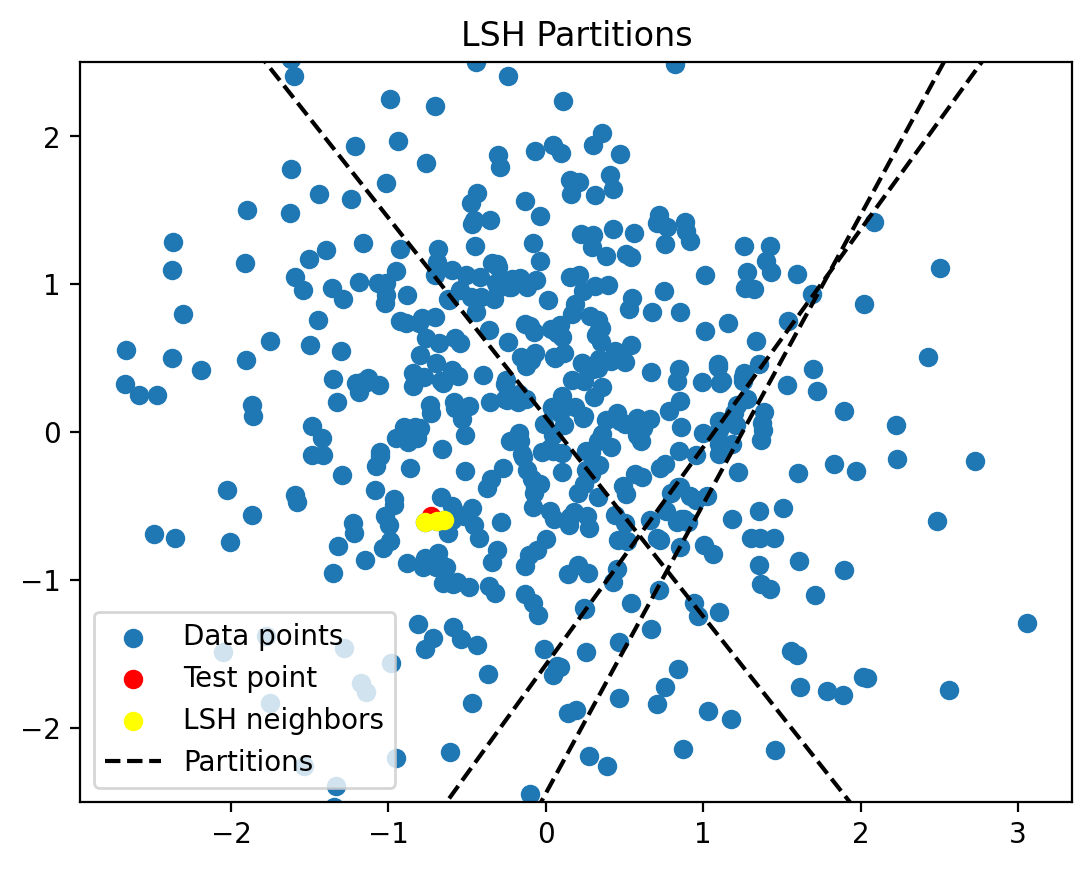

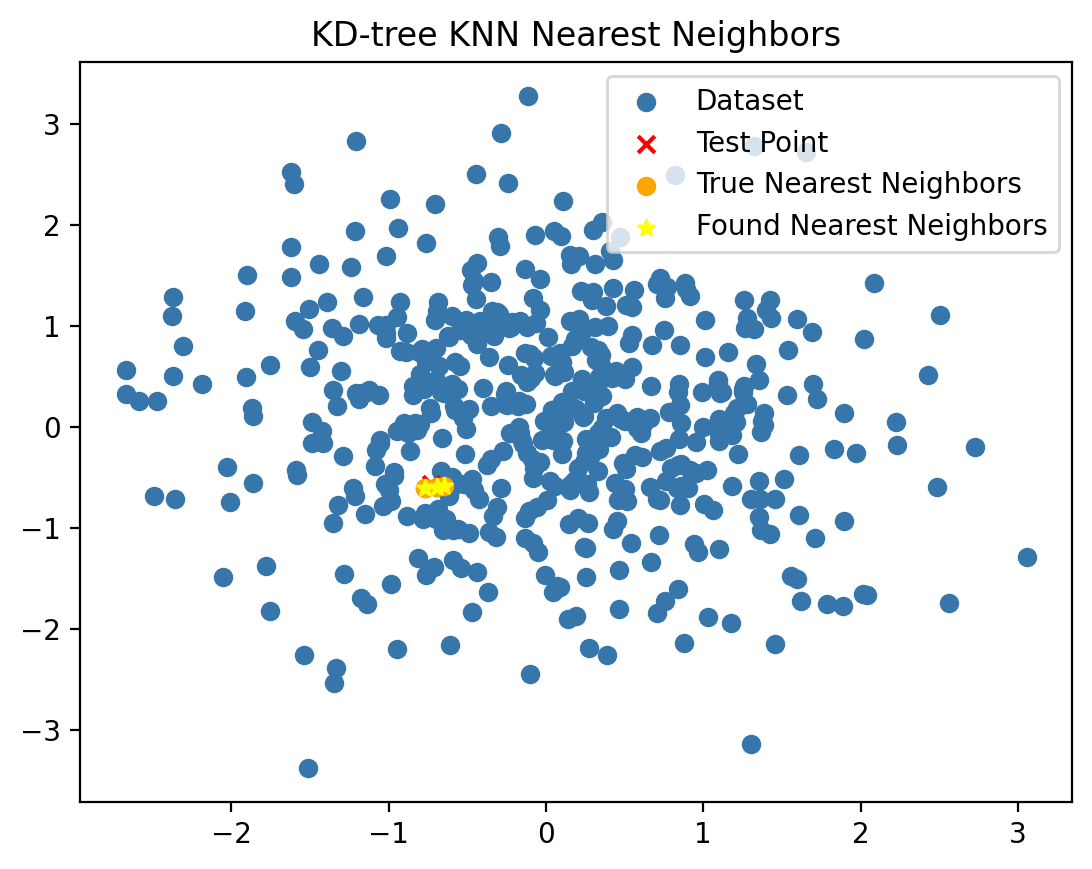

Dataset Size: 500, Dimensions: 4
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0028219144344329835
LSH KNN Training Time: 0.00012130951881408692
LSH KNN Testing Time: 0.0007385644912719727
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 36136) bytes
LSH KNN Memory Usage: (19384, 53407) bytes
KD-tree KNN Memory Usage: (4888, 17344) bytes


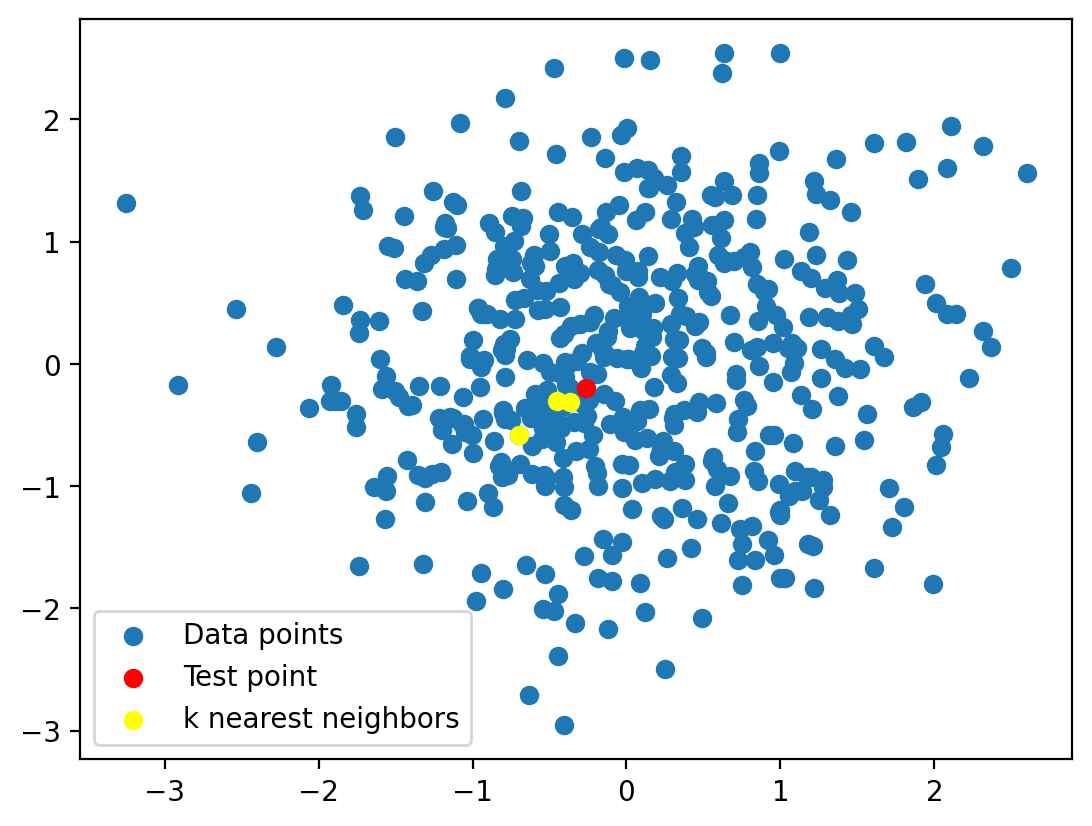

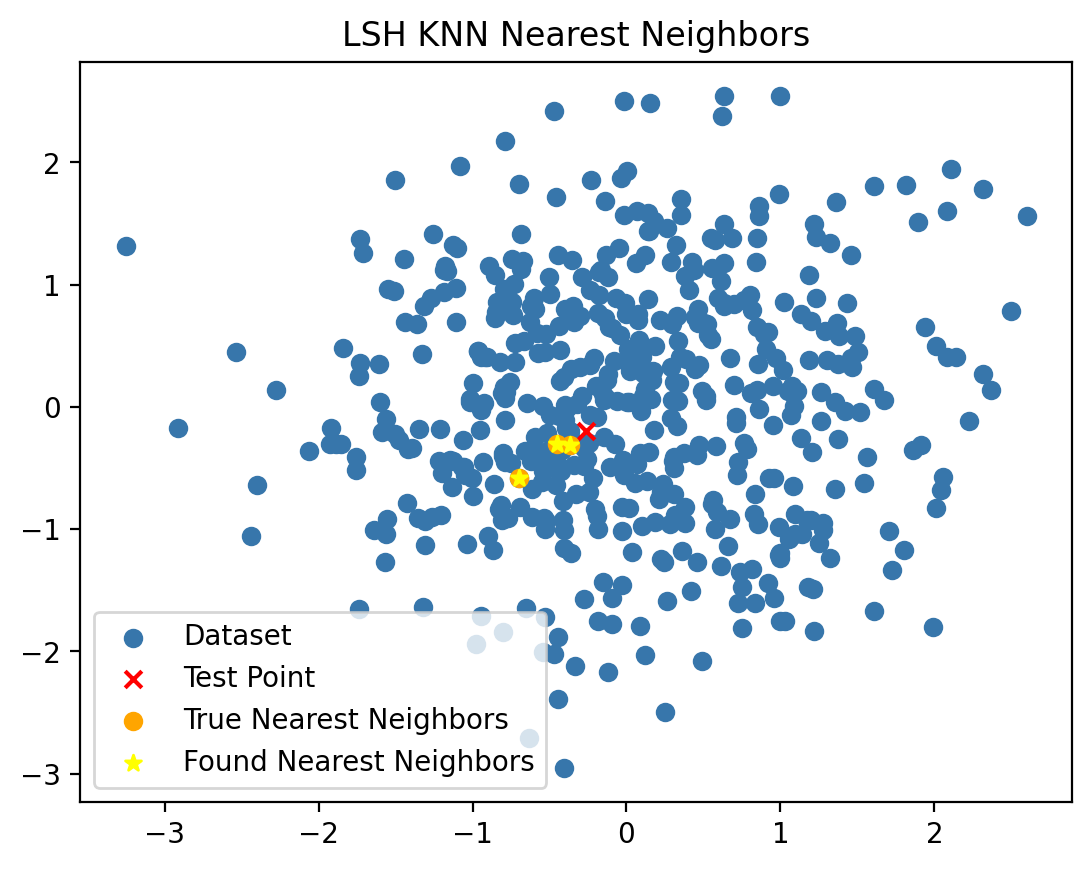

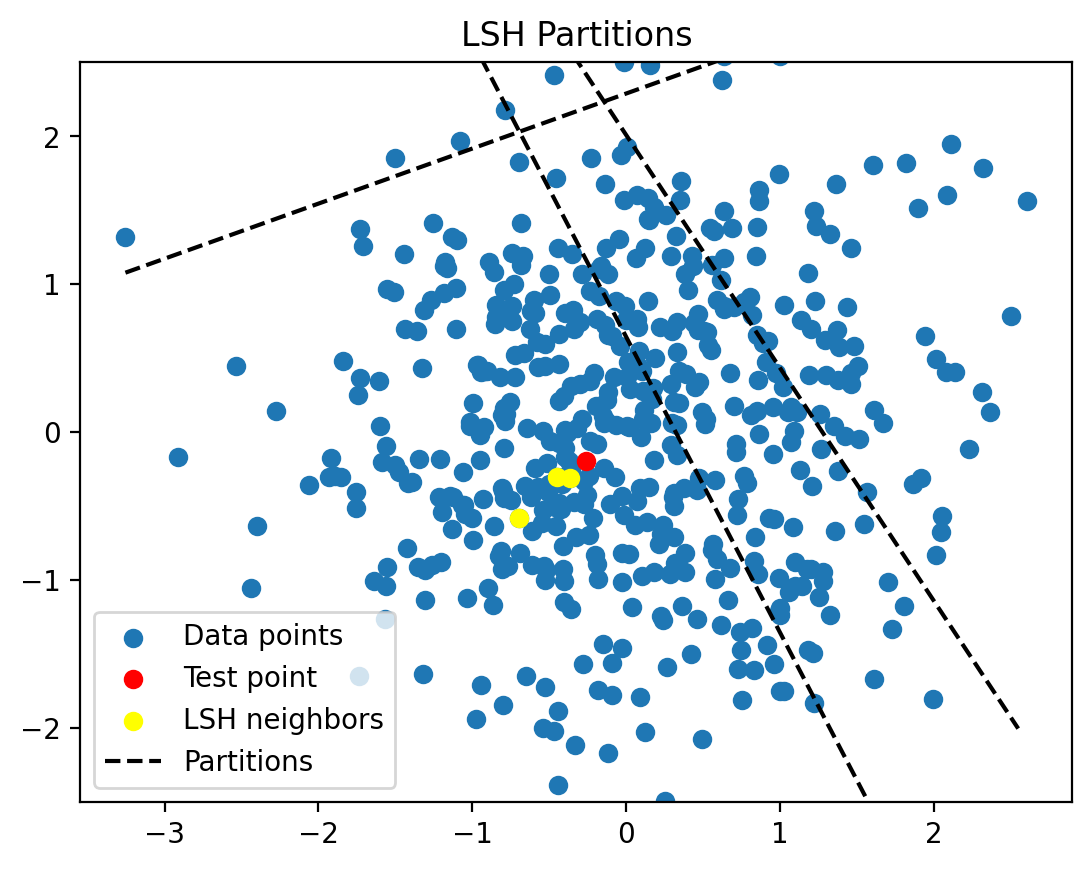

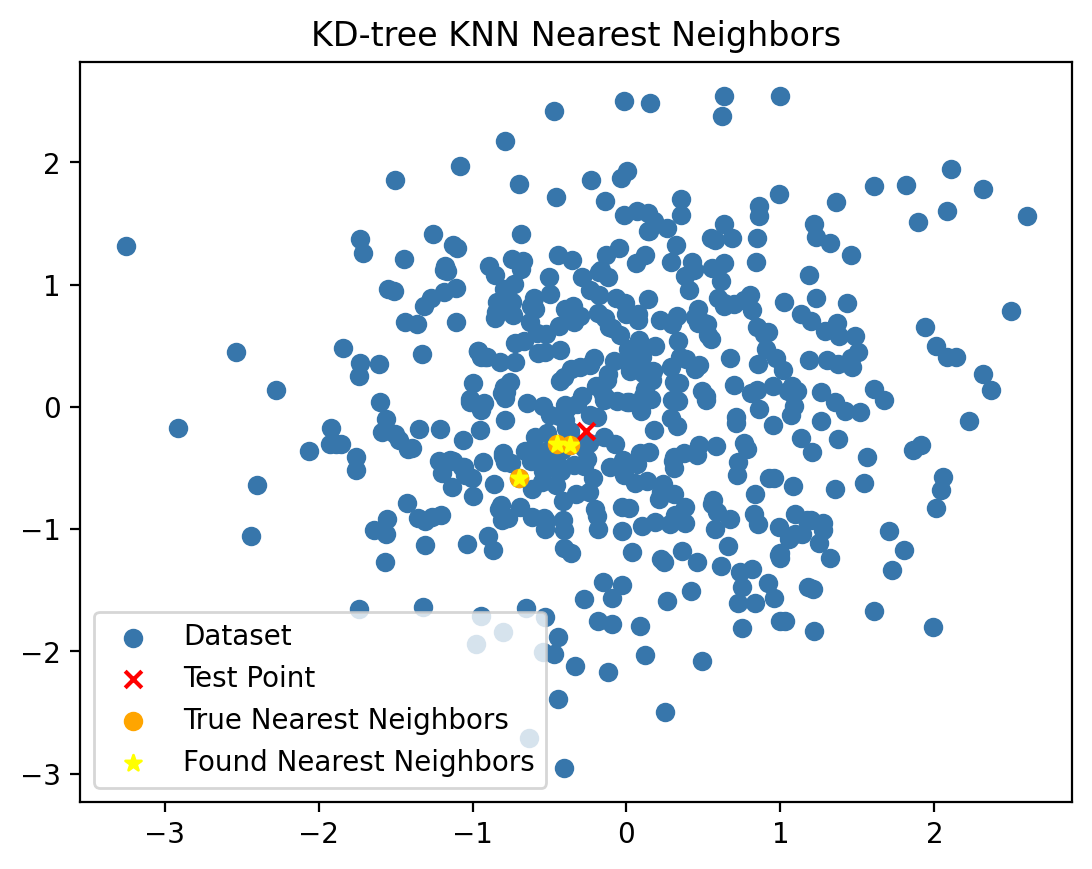

Dataset Size: 500, Dimensions: 6
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0025855391025543214
LSH KNN Training Time: 0.00014809203147888184
LSH KNN Testing Time: 0.0005010862350463867
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 36104) bytes
LSH KNN Memory Usage: (19016, 56495) bytes
KD-tree KNN Memory Usage: (4920, 25376) bytes


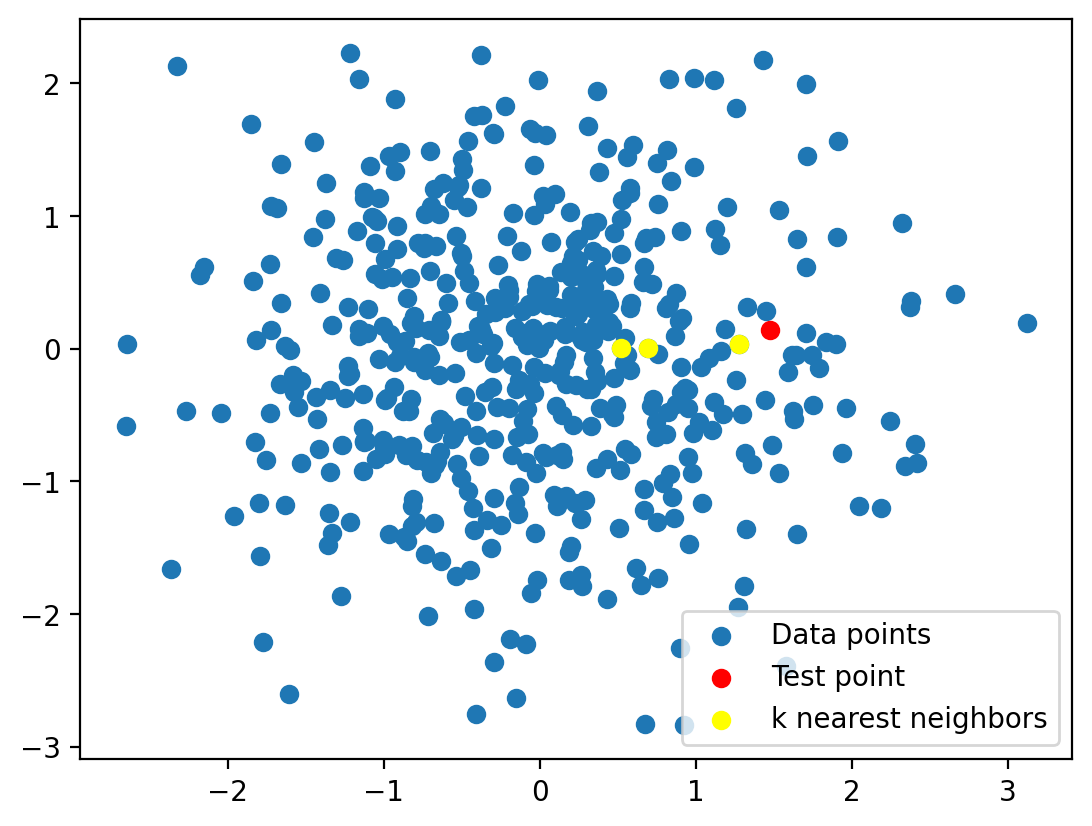

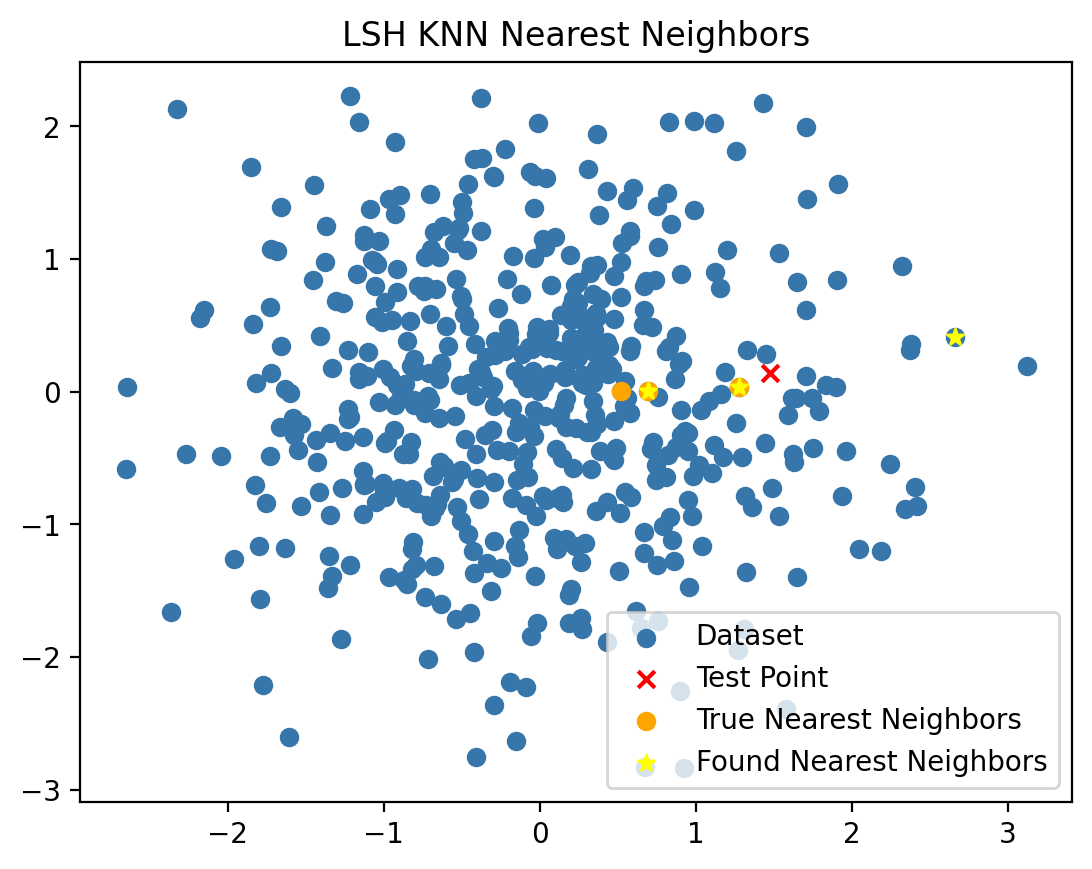

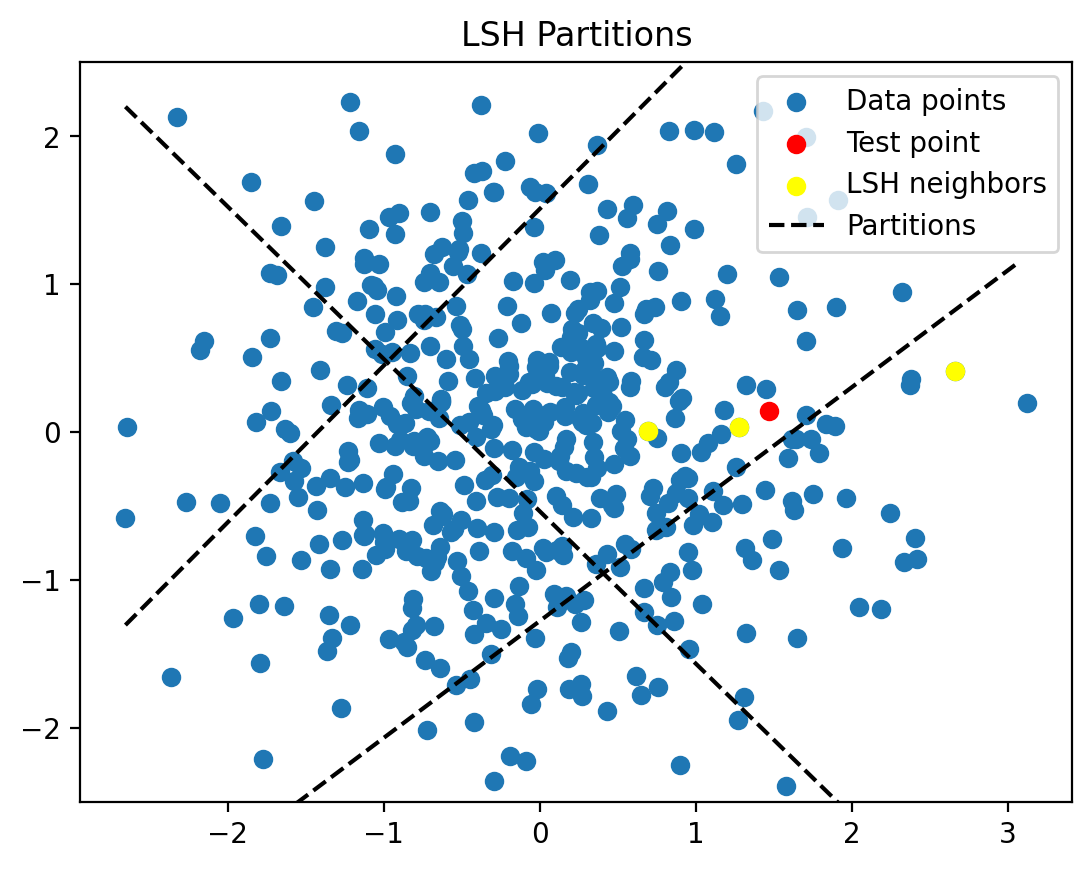

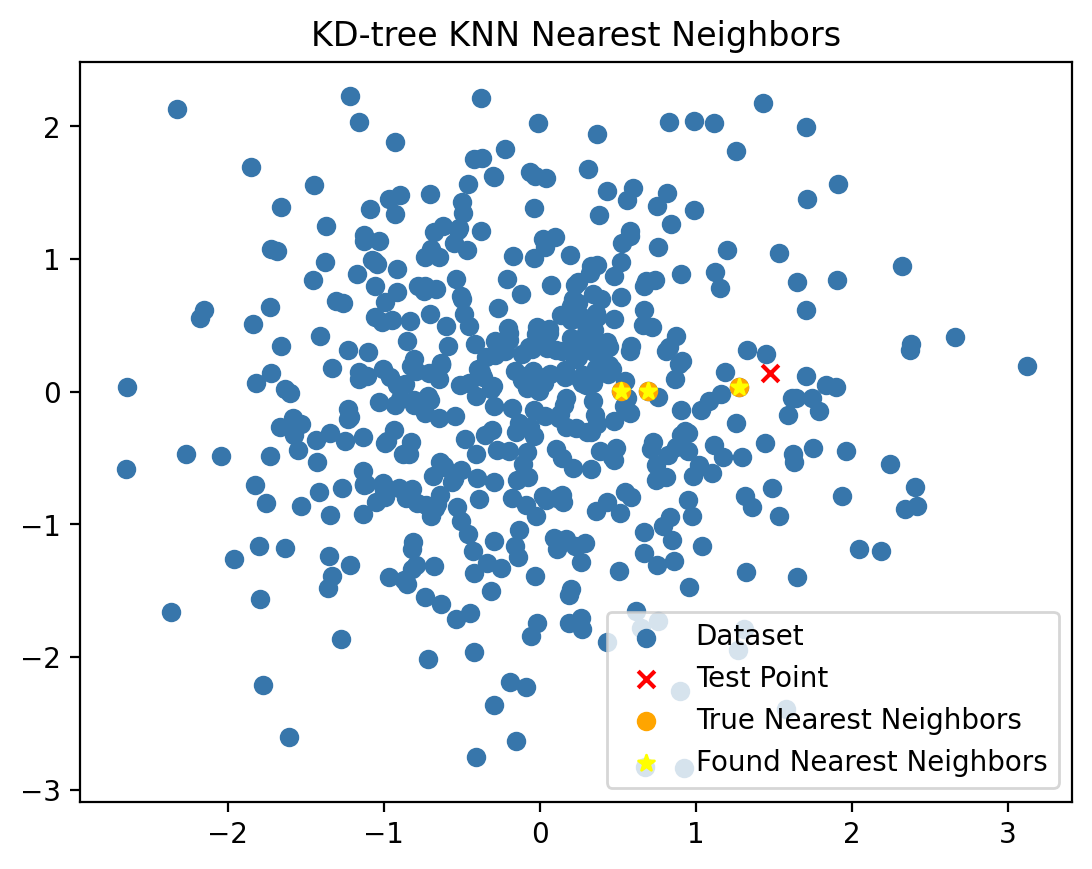

Dataset Size: 1000, Dimensions: 2
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.0051097748279571534
LSH KNN Training Time: 0.00026563835144042966
LSH KNN Testing Time: 0.0016093590259552
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 80744) bytes
LSH KNN Memory Usage: (35880, 76927) bytes
KD-tree KNN Memory Usage: (8856, 17312) bytes


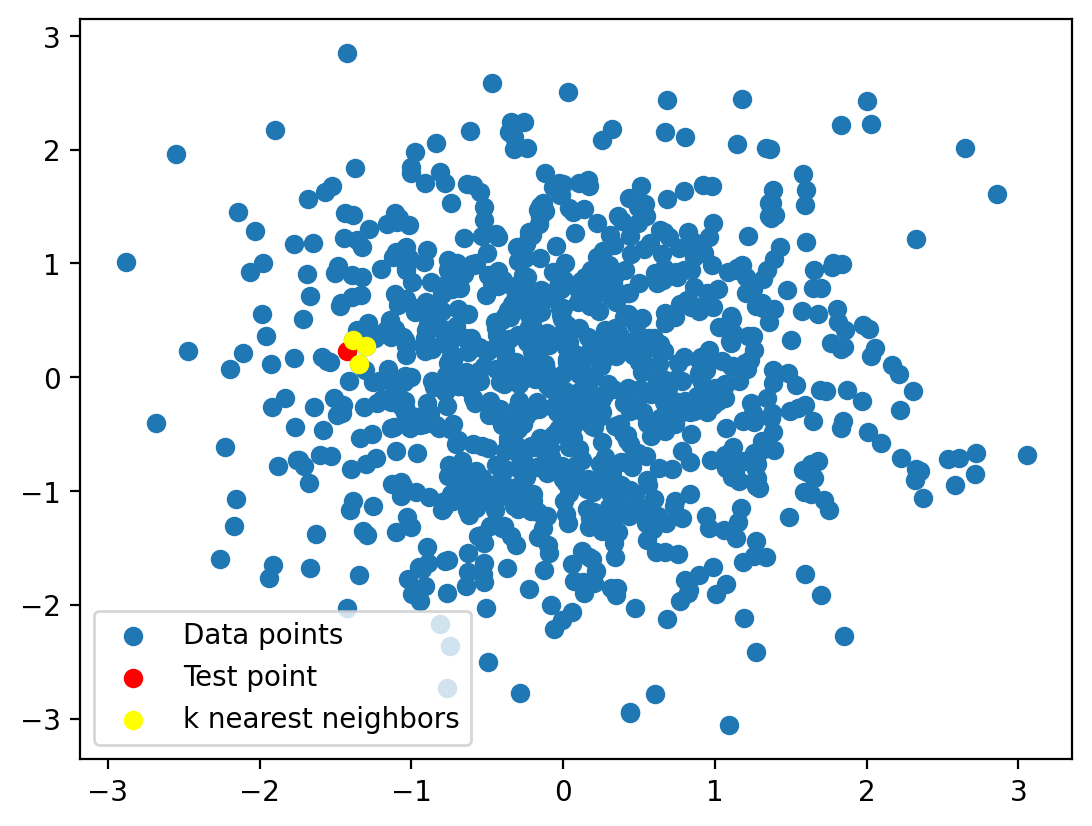

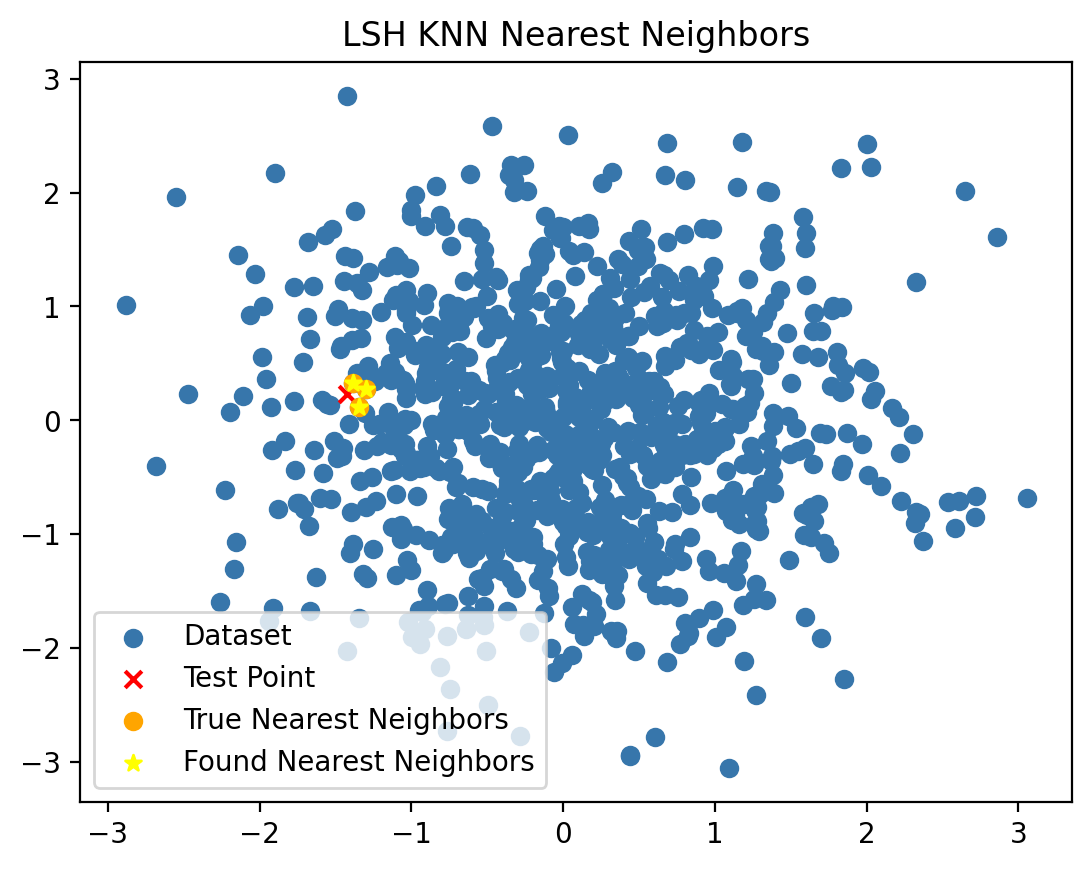

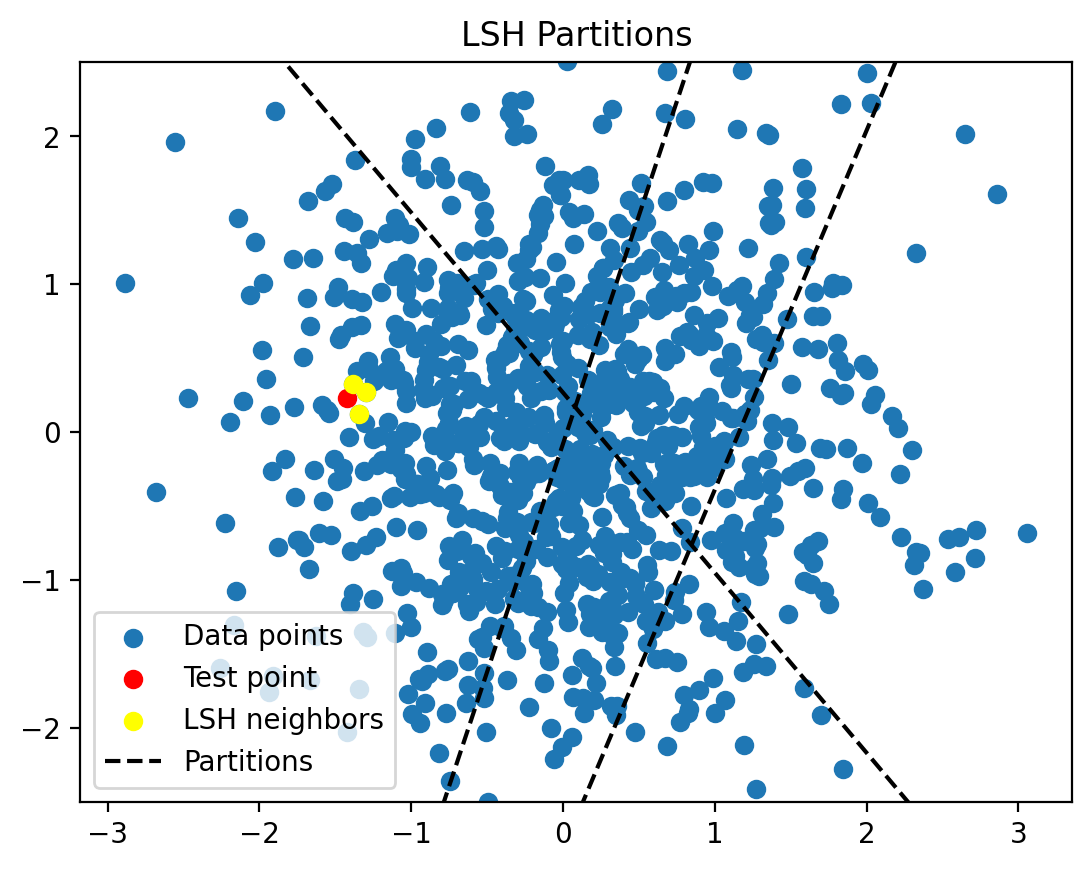

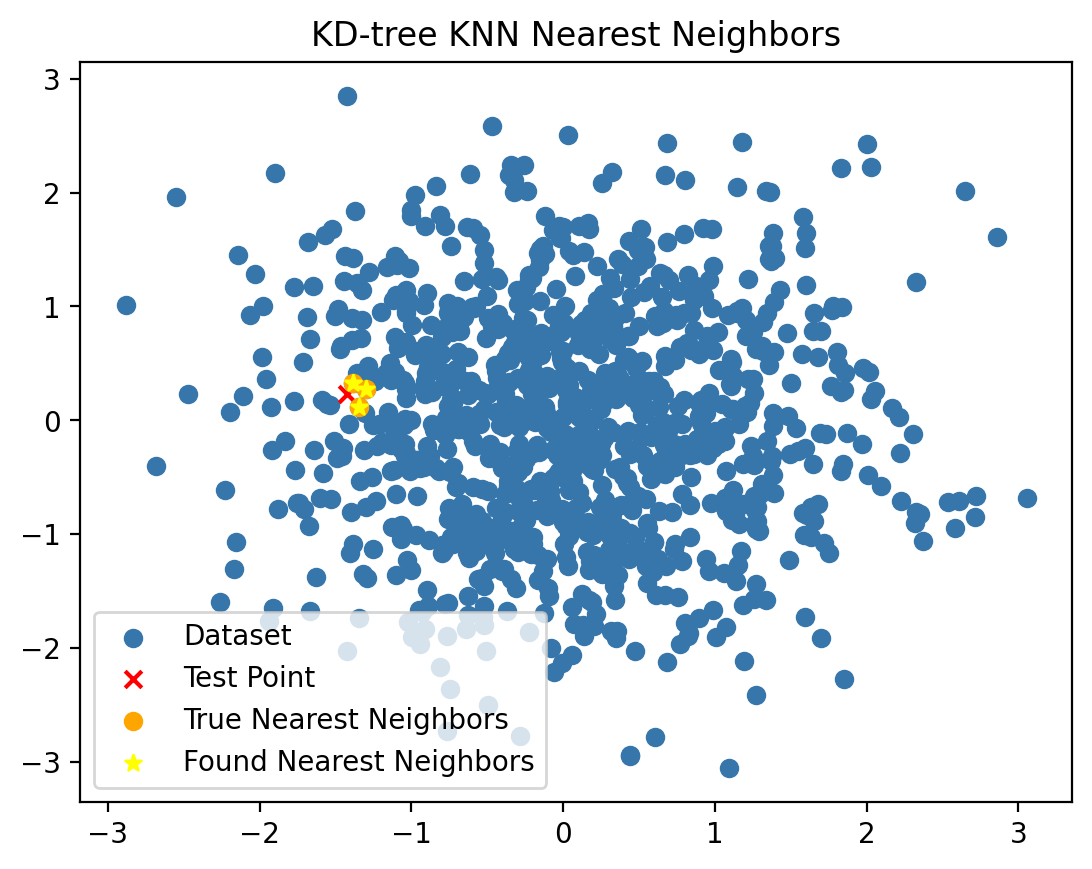

Dataset Size: 1000, Dimensions: 4
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.005140625238418579
LSH KNN Training Time: 0.0002499923706054688
LSH KNN Testing Time: 0.0012500073909759522
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 80744) bytes
LSH KNN Memory Usage: (37816, 93343) bytes
KD-tree KNN Memory Usage: (8888, 33344) bytes


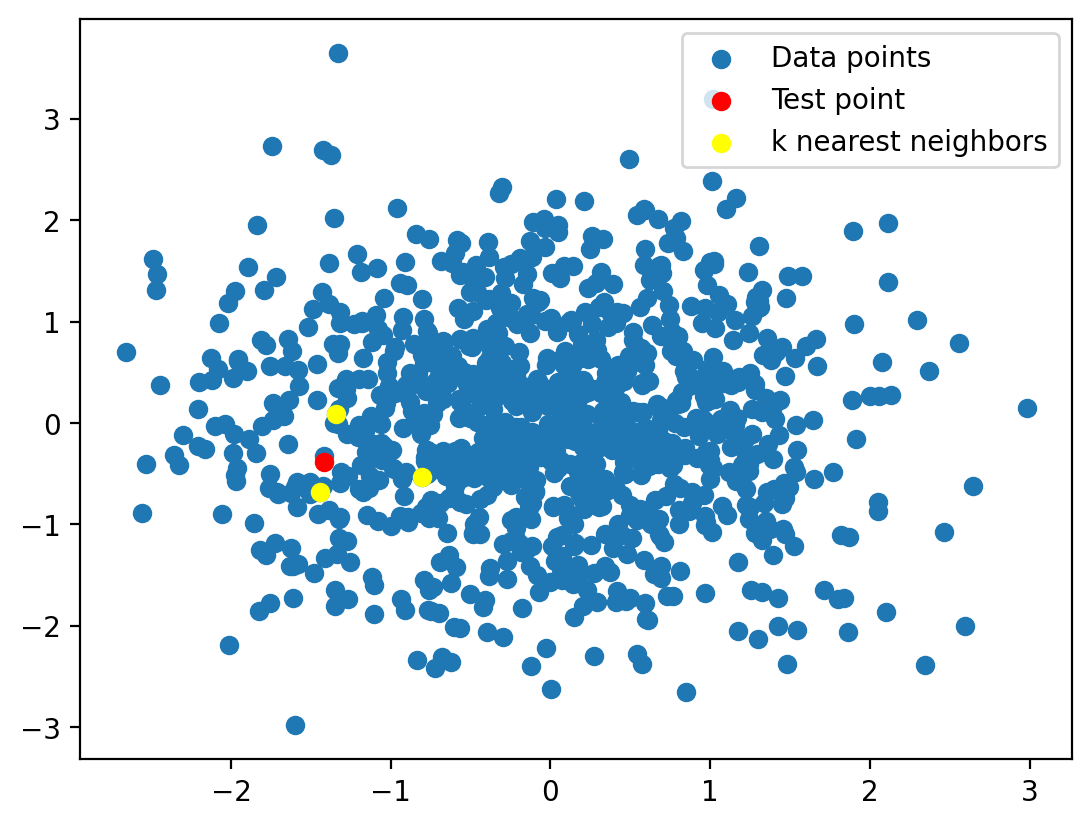

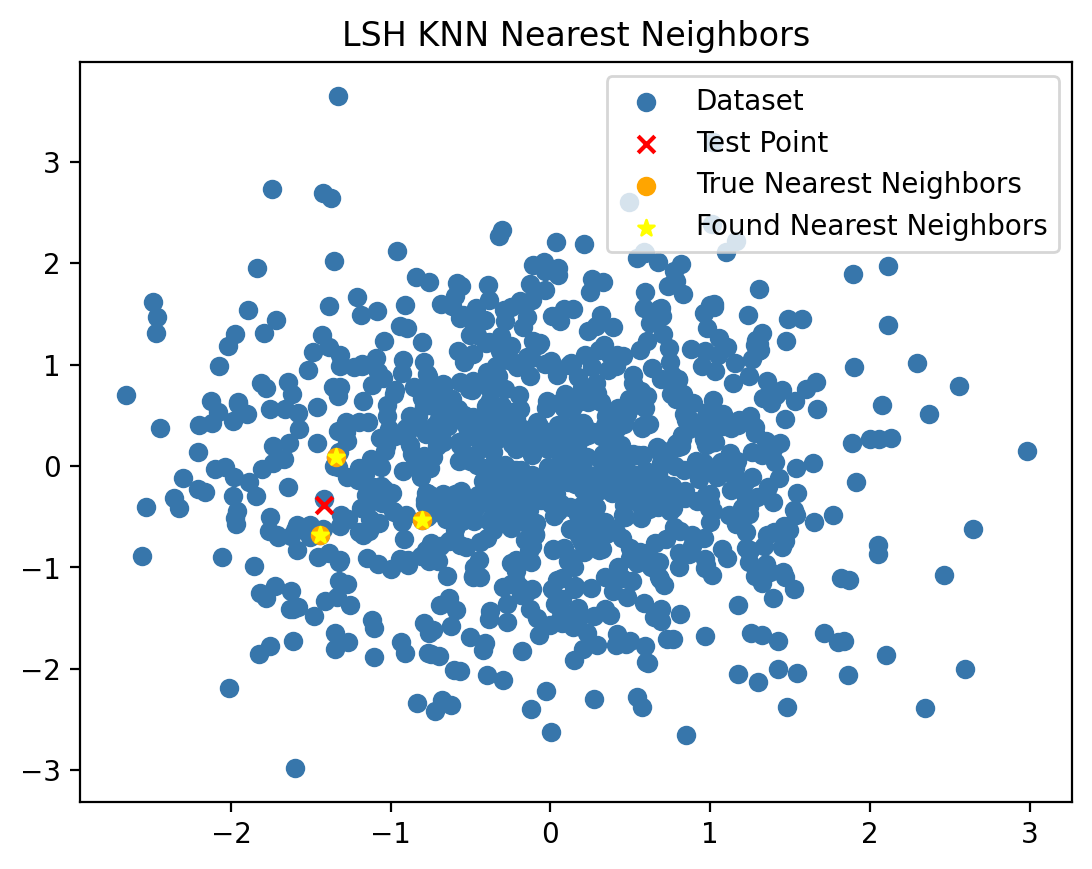

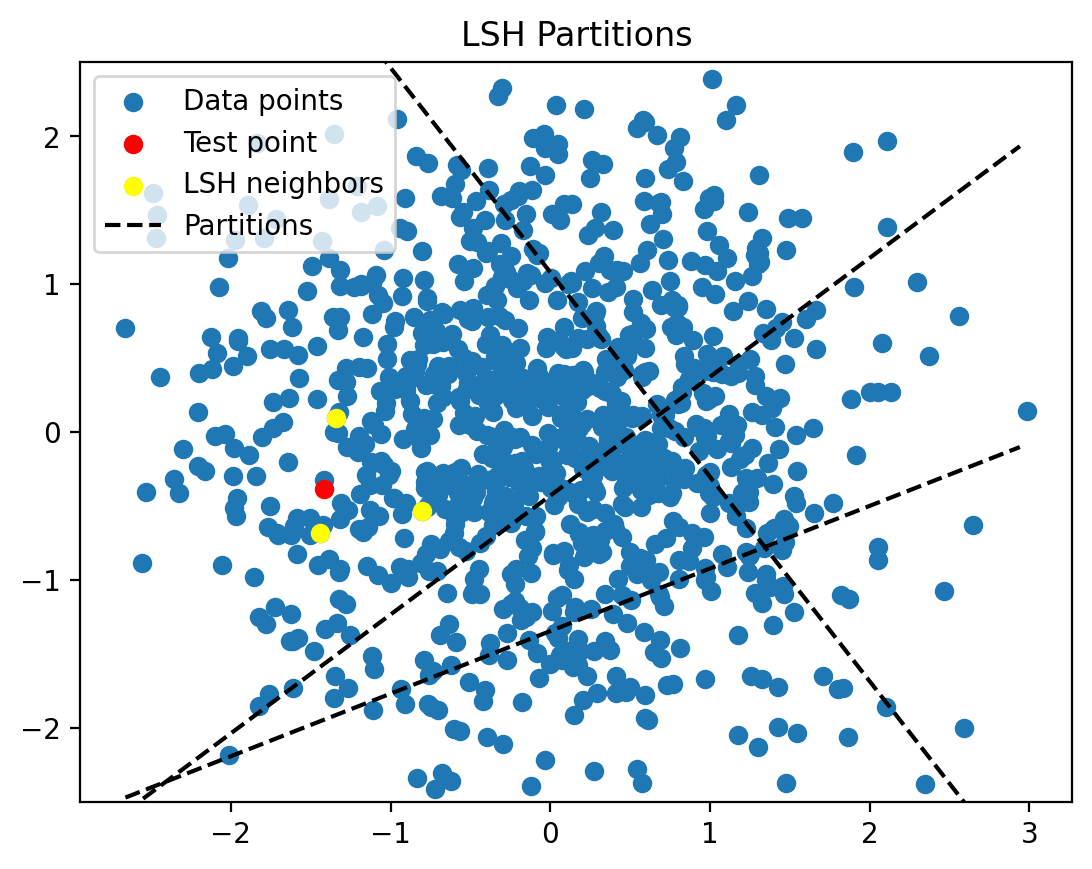

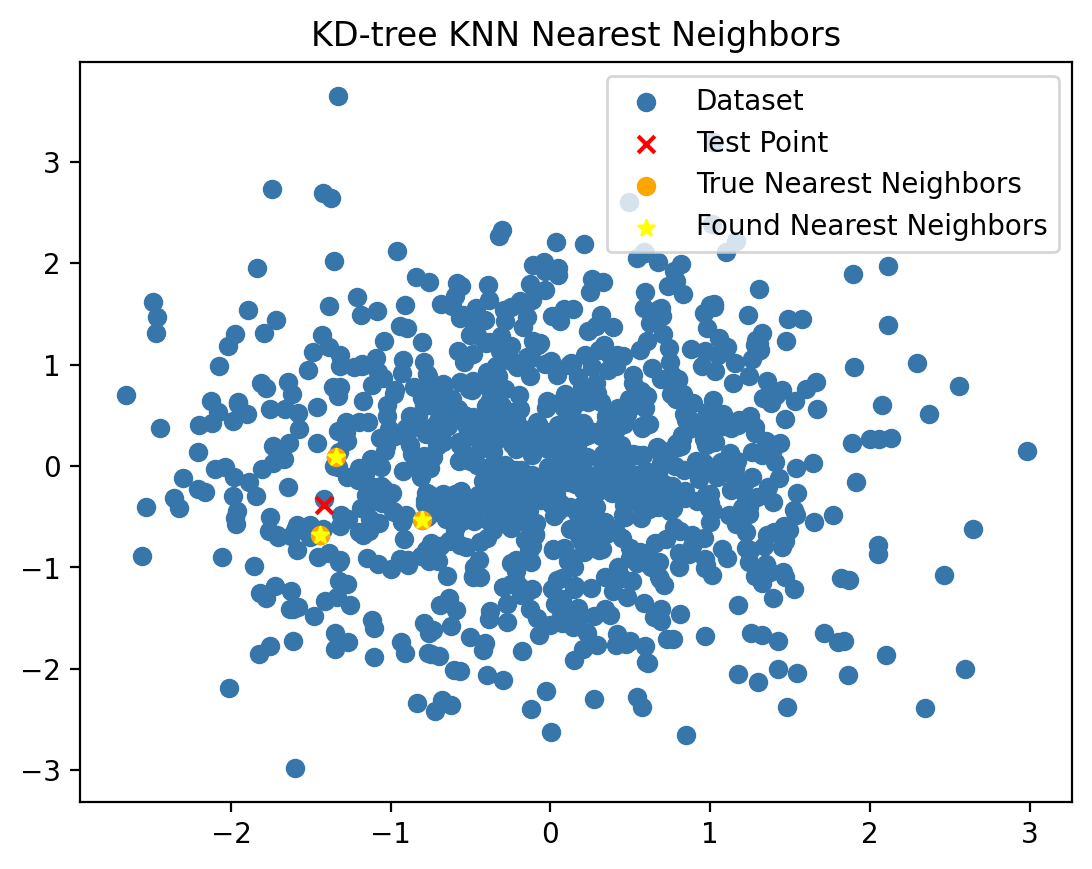

Dataset Size: 1000, Dimensions: 6
Naive KNN Training Time: 0
Naive KNN Testing Time: 0.005110572576522827
LSH KNN Training Time: 0.00040629029273986817
LSH KNN Testing Time: 0.0009378550052642822
KD-tree KNN Training Time: 0.0
KD-tree KNN Testing Time: 0.0
Naive KNN Memory Usage: (320, 80744) bytes
LSH KNN Memory Usage: (44552, 120127) bytes
KD-tree KNN Memory Usage: (8920, 49376) bytes


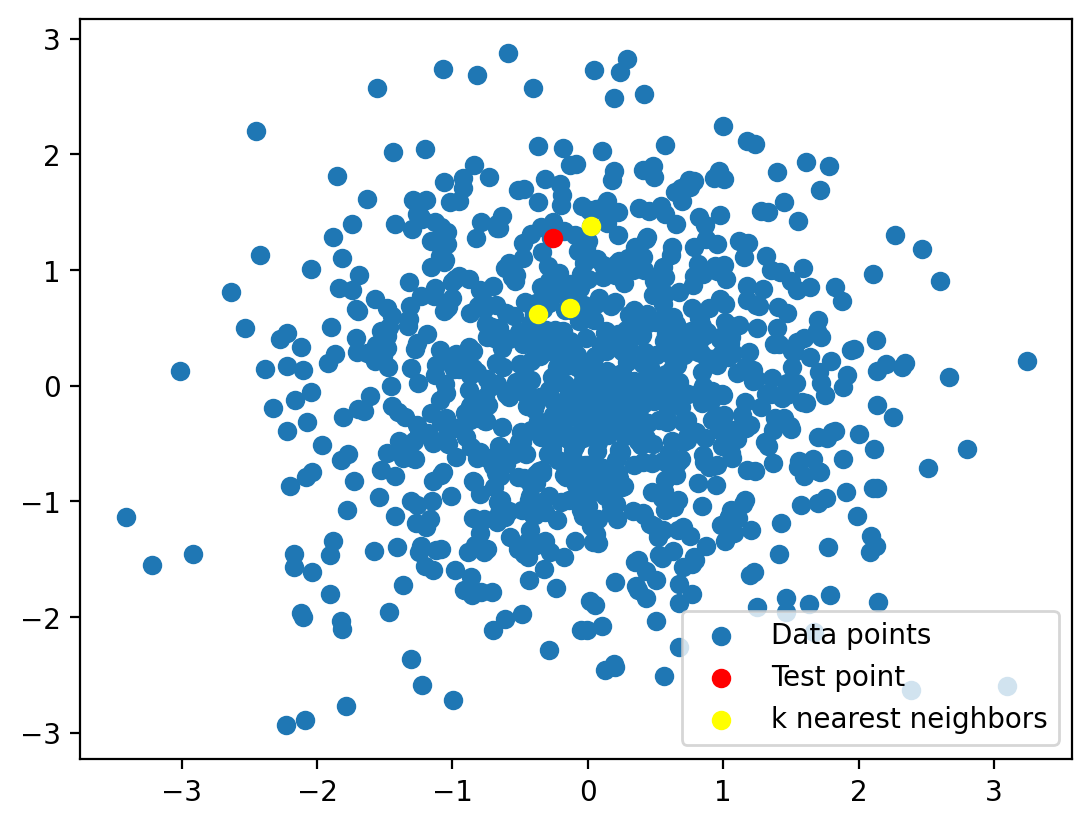

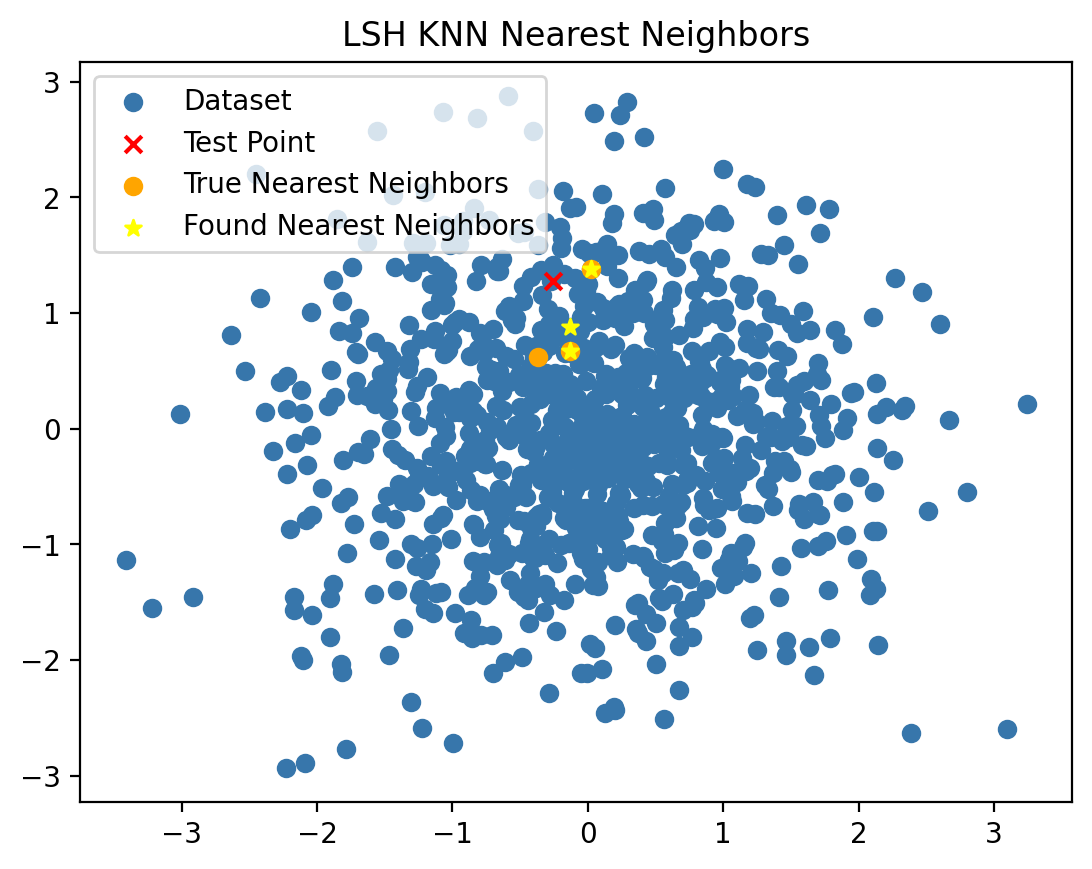

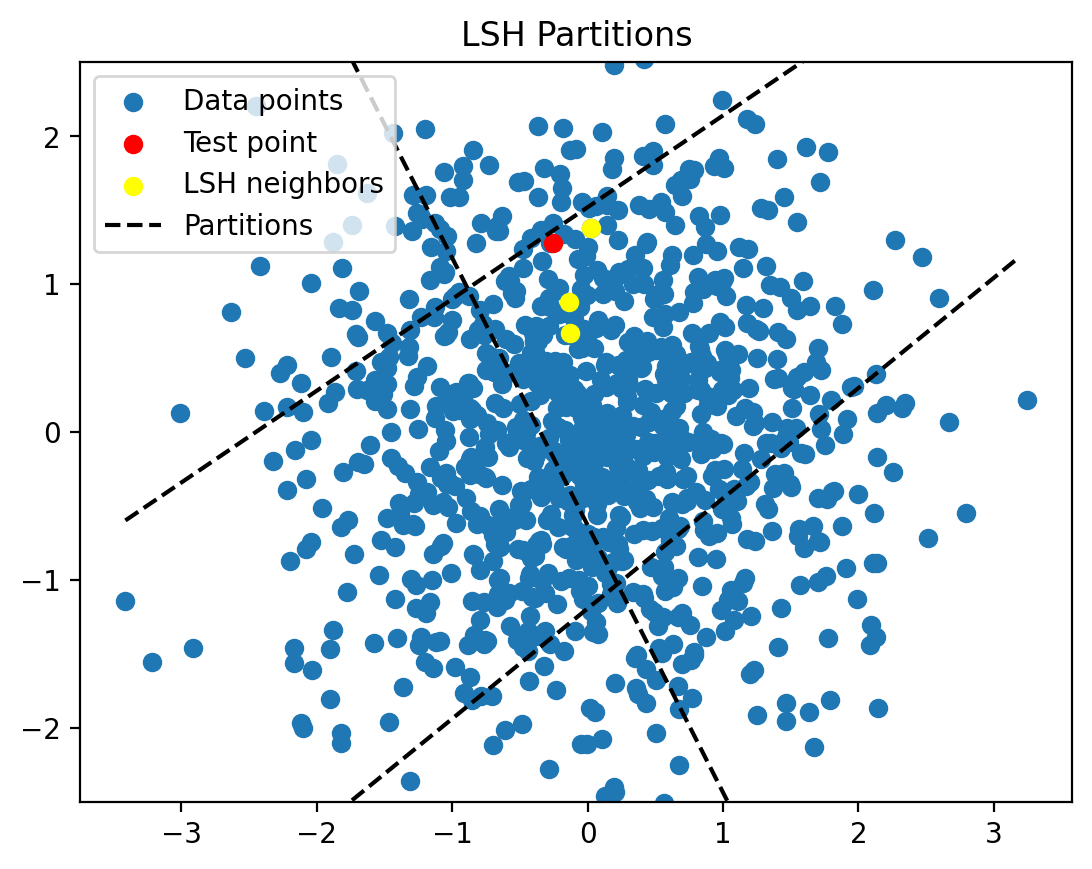

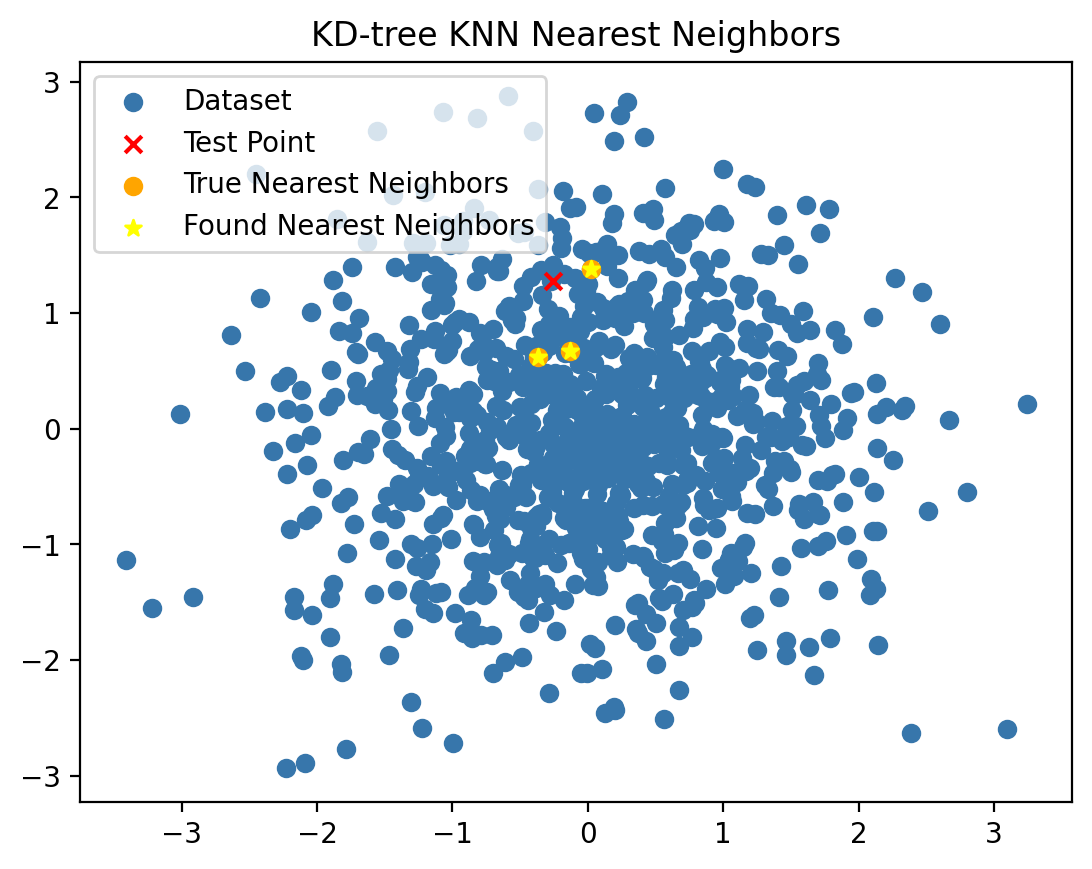

In [ ]:
N_values = [100, 500, 1000]
D_values = [2, 4, 6]
K = 3
for N in N_values:
    for D in D_values:
        print(f"Dataset Size: {N}, Dimensions: {D}")
        dataset = generate_random_dataset(N, D)
        test_data = np.random.randn(D)
        # Naive KNN
        neighbors_naive = naive_KNN(K, dataset, test_data)
        neighbors = np.array([list(neighbors_naive[0]), list(neighbors_naive[1]), list(neighbors_naive[2])])
        naive_training_time, naive_testing_time = measure_time1(dataset, test_data, K)
        print("Naive KNN Training Time:", naive_training_time)
        print("Naive KNN Testing Time:", naive_testing_time)
        # LSH KNN
        p = 3
        W, hash_dict = creating_bins(p, dataset)
        neighbors_lsh = find_LSH_neighbors(dataset, test_data, p, K, W, hash_dict)
        lsh_neighbors = np.array([list(neighbors_lsh[0]), list(neighbors_lsh[1]), list(neighbors_lsh[2])])
        lsh_training_time, lsh_testing_time = measure_time2(dataset, test_data, K)
        print("LSH KNN Training Time:", lsh_training_time)
        print("LSH KNN Testing Time:", lsh_testing_time)
        # KD-tree KNN
        kdtree_model = KDTreeKNN(train_data=dataset)
        kdtree_training_time, kdtree_testing_time = measure_time3(kdtree_model, dataset, test_data, K)
        print("KD-tree KNN Training Time:", kdtree_training_time)
        print("KD-tree KNN Testing Time:", kdtree_testing_time)
        naive_memory_usage = memory_usage_knn(dataset, test_data, K)
        lsh_memory_usage = memory_usage_lsh(dataset, test_data, K)
        kdtree_memory_usage = memory_usage_kd(dataset, test_data, K)
        print("Naive KNN Memory Usage:", naive_memory_usage, "bytes")
        print("LSH KNN Memory Usage:", lsh_memory_usage, "bytes")
        print("KD-tree KNN Memory Usage:", kdtree_memory_usage, "bytes")
        # Naive KNN
        plot_knn(dataset, test_data, neighbors)
        # LSH KNN
        visualize_missed_neighbors(dataset, neighbors, lsh_neighbors, test_data, K, 'LSH KNN Nearest Neighbors')
        plot_lsh(W, dataset, test_data, lsh_neighbors)
        # KD-tree KNN
        kdtree_nearest_indices = kdtree_model.query(test_data, K)
        kdtree_nearest_neighbors = dataset[kdtree_nearest_indices]
        visualize_missed_neighbors(dataset, neighbors, kdtree_nearest_neighbors, test_data, K, 'KD-tree KNN Nearest Neighbors')

### **Effect of Dataset Size (\(N\))**

1. **Naive KNN**:
   - **Training Time**: Since Naive KNN does not involve a preprocessing or training phase, its training time is negligible (\(0\)).
   - **Testing Time**: Testing time increases linearly with \(N\) because Naive KNN computes distances between the query point and all \(N\) data points for each query.

2. **LSH KNN**:
   - **Training Time**: LSH involves creating hash tables, so training time increases slightly with \(N\) but remains low due to hashing efficiency.
   - **Testing Time**: Testing time grows with \(N\) but less sharply than Naive KNN due to its approximate nature, which reduces the number of exact distance calculations.

3. **KD-tree KNN**:
   - **Training Time**: Building the KD-tree increases with \(N\) because it involves sorting data into a tree structure. However, in this case, training time is negligible due to optimized implementation.
   - **Testing Time**: KD-tree testing is faster compared to Naive KNN since the tree structure reduces the number of comparisons needed. Testing time remains effectively constant for smaller datasets due to logarithmic complexity.

---

### **Effect of Dimensionality (\(D\))**

1. **Naive KNN**:
   - **Training Time**: Not affected by \(D\).
   - **Testing Time**: Testing time remains linear with \(N\) but increases slightly with \(D\) due to higher computational cost for calculating distances in higher-dimensional spaces.

2. **LSH KNN**:
   - **Training Time**: Hashing becomes more complex as \(D\) increases, leading to a moderate increase in training time.
   - **Testing Time**: Testing time slightly increases with \(D\) as LSH needs more hash tables to ensure accurate approximations in higher dimensions.

3. **KD-tree KNN**:
   - **Training Time**: In higher dimensions, the efficiency of the KD-tree diminishes as data becomes sparsely distributed, leading to longer tree-building times.
   - **Testing Time**: KD-tree testing performance degrades with \(D\) because the number of comparisons increases as the tree structure becomes less efficient. For very high \(D\), KD-tree may approach the performance of Naive KNN.

---

### **Key Observations**
1. **Dataset Size Impact**:
   - Testing time grows fastest for Naive KNN, moderately for LSH, and slowest for KD-tree as \(N\) increases.
   - Memory usage scales with \(N\) for all methods, but LSH consumes more memory due to hash table storage.

2. **Dimensionality Impact**:
   - Higher \(D\) increases the computational load for all methods, but Naive KNN and LSH handle the increase better than KD-tree.
   - KD-tree suffers significantly in high dimensions due to the "curse of dimensionality," which reduces its partitioning efficiency.

3. **Overall Performance**:
   - For small datasets or low dimensions, all methods perform well, with Naive KNN being simple and effective.
   - For large datasets and moderate dimensions, LSH is efficient due to its approximate nature.
   - KD-tree is ideal for low-dimensional problems but becomes less suitable as \(D\) increases.